# A - Forecast on Google Search Console Data

## 1 - Import Packages

In [ ]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols

# For saving models
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ủy quyền "Ai cũng có thể xem được file cho Sheet rồi mới copy link Sheet vào"
# Dataset chỉ dùng số tổng hợp hằng ngày của các Metrics, không chia theo các Dimension khác như Từ khóa, Trang URL, Quốc gia
# Dataset có loại tìm kiếm mặc định là Website, các loại tìm kiếm khác là Không có
url = 'https://docs.google.com/spreadsheets/d/1tJLQ_A_SNBan4ms7GuEQogrbutDxOd9FcWz1b7rtomA/export?format=csv'
df = pd.read_csv(url)

## 2 - EDA

### 2.1 - Overview

In [ ]:
# Convert CTR sang float64, CTR được tính = Lượt nhấp / Lượt hiển thị
df["Click Through Rate"] = df["Lượt nhấp"] / df["Lượt hiển thị"] * 100
# Drop bỏ cột CTR cũ
df = df.drop("CTR", axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ngày                388 non-null    object 
 1   Lượt nhấp           388 non-null    int64  
 2   Lượt hiển thị       388 non-null    int64  
 3   Vị trí              388 non-null    float64
 4   Click Through Rate  388 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 15.3+ KB


In [ ]:
df.describe()

,Lượt nhấp,Lượt hiển thị,Vị trí,Click Through Rate
count,388.000000,388.000000,388.000000,388.000000
mean,4.247423,201.896907,17.376082,2.070953
std,3.279506,96.107362,5.078078,1.364539
min,0.000000,29.000000,7.790000,0.000000
25%,2.000000,139.500000,13.137500,1.266617
50%,4.000000,209.000000,16.650000,1.889768
75%,6.000000,269.250000,21.407500,2.742080
max,18.000000,469.000000,32.460000,10.909091


*   Lượt nhấp: Trung bình 4 lượt nhấp/ngày
*   Lượt hiển thị: Trung bình 201 lượt hiển thị/ngày, Hiển thị tối thiểu là 29 lượt hiển thị/ngày
*   Click Through Rate (CTR): Trung bình 2.07%/ngày
*   Vị trí của Website: Vị trí trung bình của Website là 17.37
*   Không có có giá trị null ở dòng/cột nào.

In [ ]:
df.duplicated().sum()

0

Không có giá trị trùng nào

### 2.2 - Check Outlier

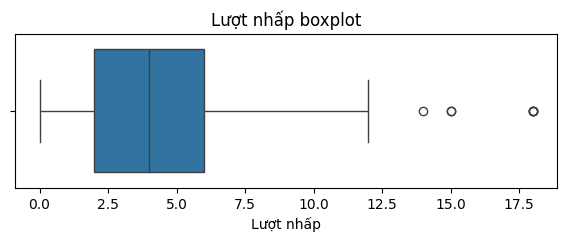

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Lượt nhấp'])
plt.title('Lượt nhấp boxplot')
plt.show()

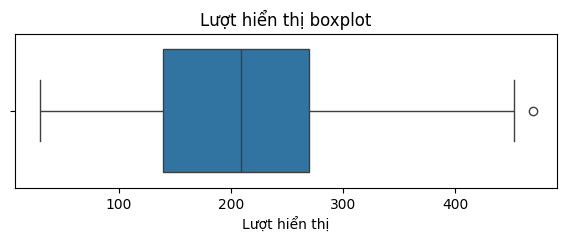

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Lượt hiển thị'])
plt.title('Lượt hiển thị boxplot')
plt.show()

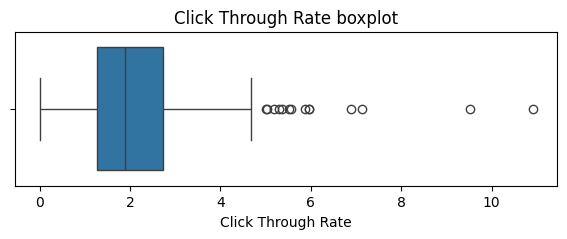

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Click Through Rate'])
plt.title('Click Through Rate boxplot')
plt.show()

CTR có 1 số Outlier nhất định với CTR > 4%

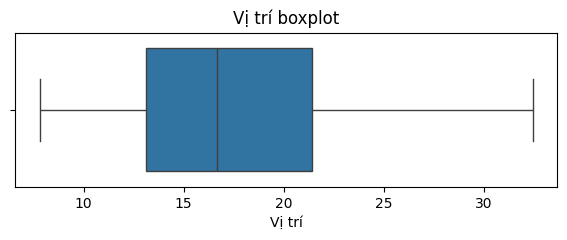

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Vị trí'])
plt.title('Vị trí boxplot')
plt.show()


In [ ]:
# Check các Outlier ở các biến Lượt nhấp, Lượt hiển thị, CTR
(df["Click Through Rate"]>4).sum()*100/df["Click Through Rate"].sum()

2.9868211078536153

In [ ]:
# Check các Outlier ở các biến Lượt nhấp, Lượt hiển thị, CTR
(df["Lượt nhấp"]>13).sum()*100/df["Lượt nhấp"].sum()

0.42475728155339804

Tỷ trọng Outlier là 3%, không đáng kể. Tiếp tục điều tra chi tiết hơn về dataset

### 2.3 - Detailed EDA

#### 2.3.1 - Điều tra sự tương quan giữa các biến

In [ ]:
# Bỏ cột "Ngày" để check độ tương quan giữa các biến
df1 = df.drop(columns=["Ngày"])
df1.head()

,Lượt nhấp,Lượt hiển thị,Vị trí,Click Through Rate
0,7,228,12.79,3.070175
1,9,293,16.87,3.071672
2,9,238,12.04,3.781513
3,9,286,14.43,3.146853
4,5,301,15.15,1.661130


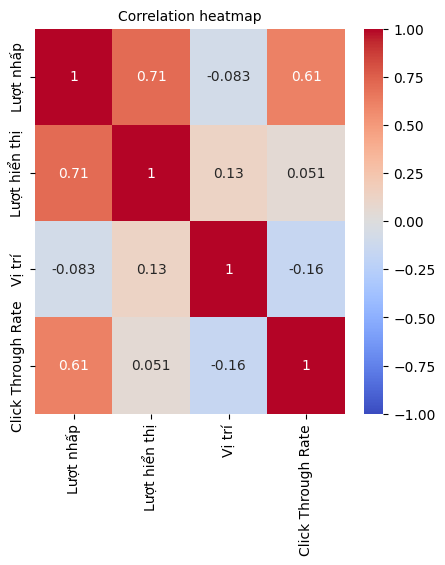

In [ ]:
# Calculate correlation and plot heatmap
plt.figure(figsize=(5,5))
corr_matrix = df1.corr(method='pearson')
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap', fontsize=10)
plt.show()

Loại bỏ outlier xem kết quả tương quan có thay đổi nhiều không (Outier: Click Through Rate > 5%)

In [ ]:
df1= df1[df1["Click Through Rate"]<5]
df1.describe()

,Lượt nhấp,Lượt hiển thị,Vị trí,Click Through Rate
count,374.000000,374.000000,374.000000,374.000000
mean,4.120321,204.505348,17.543529,1.909782
std,3.178170,95.551924,5.080901,1.049423
min,0.000000,29.000000,7.790000,0.000000
25%,2.000000,145.000000,13.190000,1.219008
50%,4.000000,210.500000,16.840000,1.805952
75%,6.000000,271.500000,21.462500,2.656672
max,18.000000,469.000000,32.460000,4.687500


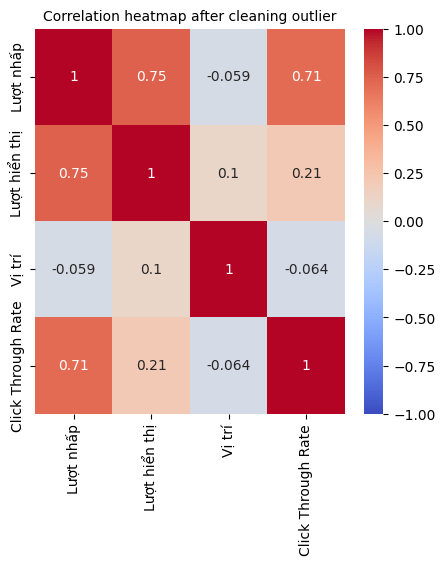

In [ ]:
# Calculate correlation and plot heatmap
plt.figure(figsize=(5,5))
corr_matrix = df1.corr(method='pearson')
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap after cleaning outlier', fontsize=10)
plt.show()

Các chỉ số tương quan không có thay đổi nhiều trong Correlation Heatmap => GIữ nguyên Outlier

Các sự tương quan trong Correlation Heatmap:
* Lượt nhấp ảnh hưởng **đáng kể** bởi lượt hiển thị, cũng là facts khi làm SEO or chạy Ads (+)
* Lượt nhấp càng cao thì CTR cũng tăng theo **đáng kể** (CTR = Lượt nhấp / Lượt hiển thị) (+)
* Lượt nhấp và CTR có ảnh hưởng ngược chiều với Vị trí Website, có thể suy luận rằng vị trí càng cao trong Top thì người dùng đã click vào càng nhiều (-)
* Vị trí ảnh hưởng bởi khả năng hiển thị (+)



#### 2.3.2 - Điều tra chi tiết hơn từ Insight 2.3.1

Vẽ thêm các biểu đồ Scatterplot để thấy sự phân bổ tương quan giữa các biến

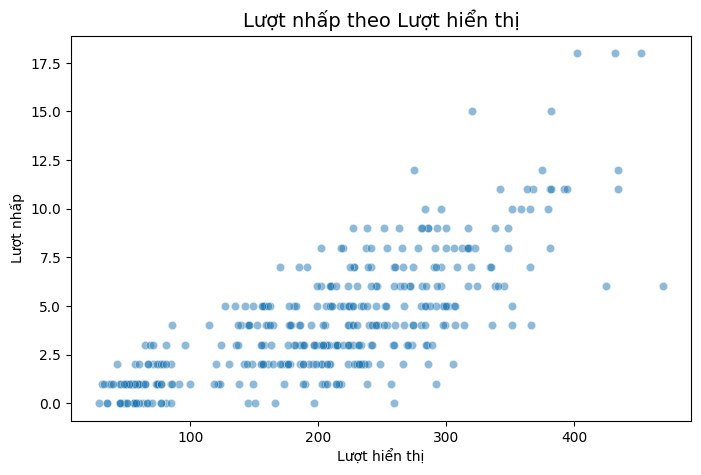

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(df1, x='Lượt hiển thị', y='Lượt nhấp', alpha=0.5)
plt.title('Lượt nhấp theo Lượt hiển thị', fontsize='14');

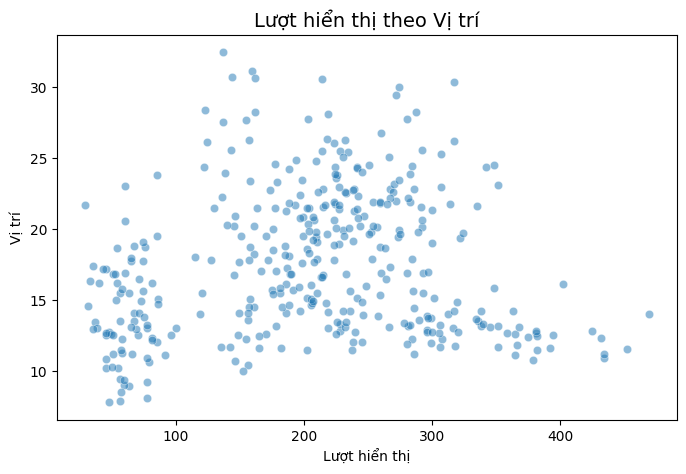

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(df1, x='Lượt hiển thị', y='Vị trí', alpha=0.5)
plt.title('Lượt hiển thị theo Vị trí', fontsize='14');

Để ý ta có thể thấy các vị trí Top 1 - Top 20 chủ yếu đều có Lượt hiển thị gần bằng 100, các vị trí từ Top 20 trở đi đều có Lượt hiển thị lớn hơn 100

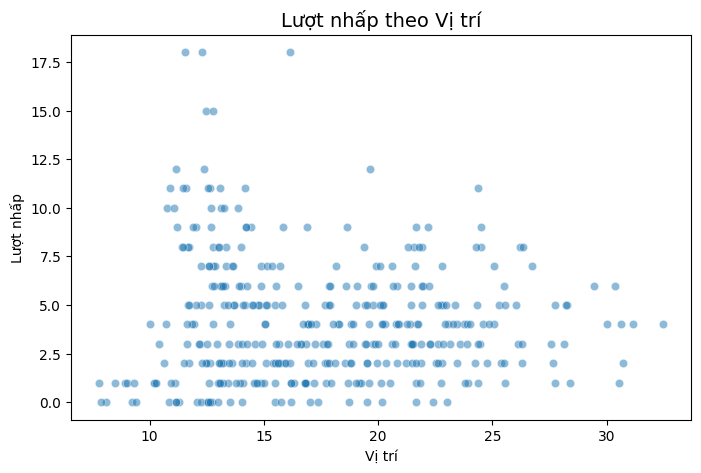

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(df1, x='Vị trí', y='Lượt nhấp', alpha=0.5)
plt.title('Lượt nhấp theo Vị trí', fontsize='14');

Lượt nhấp tập trung nhiều ở vị trí trong khoảng Top Vị trí gần 15

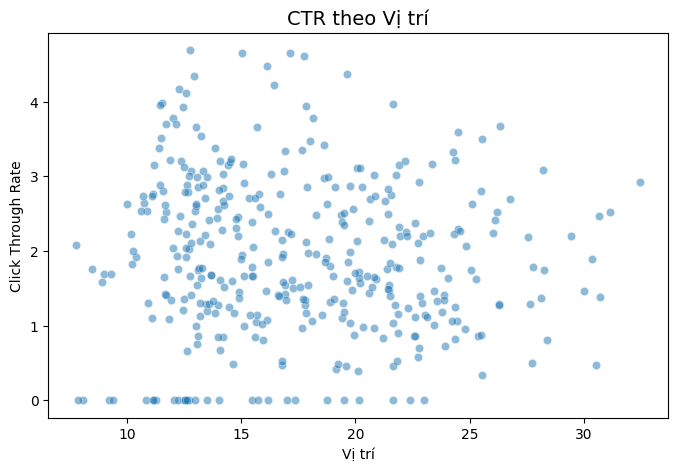

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(df1, x='Vị trí', y='Click Through Rate', alpha=0.5)
plt.title('CTR theo Vị trí', fontsize='14');

Tương tự như Lượt nhấp, CTR tập trung nhiều ở vị trí trong khoảng Top Vị trí gần 15

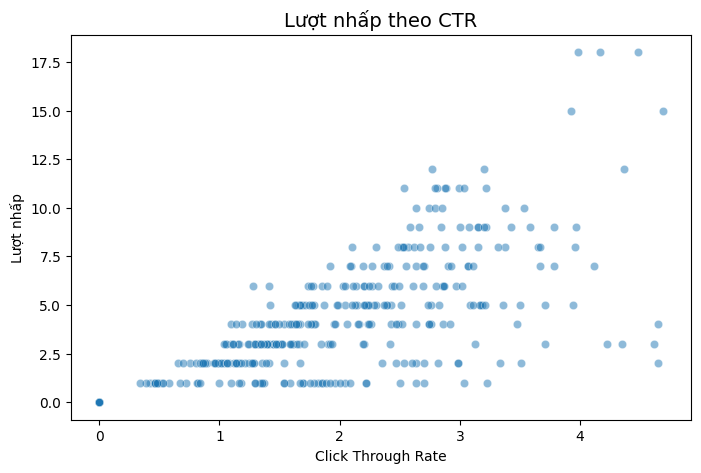

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(df1, x='Click Through Rate', y='Lượt nhấp', alpha=0.5)
plt.title('Lượt nhấp theo CTR', fontsize='14');

Tổng hợp lại về điều tra chi tiết hơn trong các Insight:
*   Lượt nhấp và CTR tập trung ở Vị trí Website trong khoảng gần Top 15 (Xếp hạng của Google cao nhất là Top 1)
*   Để ý ta có thể thấy các vị trí Top 1 - Top 20 chủ yếu đều có Lượt hiển thị gần bằng 100, các vị trí từ Top 20 trở đi đều có Lượt hiển thị lớn hơn 100



## 3 - Xây dựng mô hình hồi quy và ML

* Sử dụng mô hình hồi quy đa tuyến tính
* Các biến khác sẽ được coi là biến độc lập để xây dựng mô hình hồi quy và ML
Dự đoán tập trung vào Lượt hiển thị, Lượt nhấp

### 3.1 - Xây dựng mô hình hồi quy đa tuyến tính dự đoán Lượt nhấp (Clicks)

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df2 = df.copy()
df2.head()

,Ngày,Lượt nhấp,Lượt hiển thị,Vị trí,Click Through Rate
0,2024-08-31,7,228,12.79,3.070175
1,2024-08-30,9,293,16.87,3.071672
2,2024-08-29,9,238,12.04,3.781513
3,2024-08-28,9,286,14.43,3.146853
4,2024-08-27,5,301,15.15,1.661130


In [ ]:
# Gán y cho biến Vị trí
y = df2['Lượt nhấp']
print(y)

0      7
1      9
2      9
3      9
4      5
      ..
383    0
384    1
385    0
386    0
387    1
Name: Lượt nhấp, Length: 388, dtype: int64


In [ ]:
# Gán x cho các biến độc lập
x=df2.drop(columns=["Lượt nhấp"])
print(x)

           Ngày  Lượt hiển thị  Vị trí  Click Through Rate
0    2024-08-31            228   12.79            3.070175
1    2024-08-30            293   16.87            3.071672
2    2024-08-29            238   12.04            3.781513
3    2024-08-28            286   14.43            3.146853
4    2024-08-27            301   15.15            1.661130
..          ...            ...     ...                 ...
383  2023-08-14             58   15.76            0.000000
384  2023-08-13             52   16.79            1.923077
385  2023-08-12             51   11.16            0.000000
386  2023-08-11             45   12.64            0.000000
387  2023-08-10             48    7.79            2.083333

[388 rows x 4 columns]


Code về xây dựng mô hình hồi quy ở đây

In [ ]:
# Gán subset phân biệt biến X và Y
GSC_X = df2[["Vị trí", "Lượt hiển thị", "Click Through Rate"]]
GSC_Y = df2[["Lượt nhấp"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df2.rename(columns={'Lượt hiển thị': 'Impressions', 'Lượt nhấp': 'Clicks', 'Vị trí':'Position','Click Through Rate':'CTR'})

In [ ]:
# Define the OLS formula in string format
ols_formula = "Clicks ~ Position + Impressions + CTR"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Clicks   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     660.7
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          3.45e-151
Time:                        07:43:25   Log-Likelihood:                -658.12
No. Observations:                 388   AIC:                             1324.
Df Residuals:                     384   BIC:                             1340.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.4217      0.298     -8.140      0.000      -3.007      -1.837
Position       -0.0505      0.014     -3.715      0.000      -0.077      -0.024
Impressions     0.0234      0.001     33.042      0.000       0.022       0.025
CTR             1.3592      0.050     27.063      0.000       1.260       1.458
==============================================================================
Omnibus:                       55.292   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.150
Skew:                           0.089   Prob(JB):                    5.53e-110
Kurtosis:                       8.576   Cond. No.                         994.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*   Mô hình có R bình phương là 0.838, chứng tỏ mô hình có độ tin cậy cap là 83.8%, tất cả các biến có p-value < 0.05, chứng tỏ có ý nghĩa thống kê
*   Mô hình hồi quy đa biến có công thức như sau:
Clicks = -2.4217 - 0.0505	 * Position + 0.0234 * Impressions + 1.3592  *CTR

### 3.2 - Xây dựng mô hình hồi quy đa tuyến tính dự đoán Lượt hiển thị (Impression)

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df3 = df.copy()
df3.head()

,Ngày,Lượt nhấp,Lượt hiển thị,Vị trí,Click Through Rate
0,2024-08-31,7,228,12.79,3.070175
1,2024-08-30,9,293,16.87,3.071672
2,2024-08-29,9,238,12.04,3.781513
3,2024-08-28,9,286,14.43,3.146853
4,2024-08-27,5,301,15.15,1.661130


In [ ]:
# Gán y cho biến Vị trí
y = df3['Lượt hiển thị']
print(y)

0      228
1      293
2      238
3      286
4      301
      ... 
383     58
384     52
385     51
386     45
387     48
Name: Lượt hiển thị, Length: 388, dtype: int64


In [ ]:
# Gán x cho các biến độc lập
x=df3.drop(columns=["Lượt hiển thị"])
print(x)

           Ngày  Lượt nhấp  Vị trí  Click Through Rate
0    2024-08-31          7   12.79            3.070175
1    2024-08-30          9   16.87            3.071672
2    2024-08-29          9   12.04            3.781513
3    2024-08-28          9   14.43            3.146853
4    2024-08-27          5   15.15            1.661130
..          ...        ...     ...                 ...
383  2023-08-14          0   15.76            0.000000
384  2023-08-13          1   16.79            1.923077
385  2023-08-12          0   11.16            0.000000
386  2023-08-11          0   12.64            0.000000
387  2023-08-10          1    7.79            2.083333

[388 rows x 4 columns]


Code về xây dựng mô hình hồi quy ở đây

In [ ]:
# Gán subset phân biệt biến X và Y
GSC_X = df3[["Vị trí", "Lượt nhấp", "Click Through Rate"]]
GSC_Y = df3[["Lượt hiển thị"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df3.rename(columns={'Lượt hiển thị': 'Impressions', 'Lượt nhấp': 'Clicks', 'Vị trí':'Position','Click Through Rate':'CTR'})

In [ ]:
# Define the OLS formula in string format
ols_formula = "Impressions ~ Position + Clicks + CTR"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Impressions   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     374.9
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          1.08e-113
Time:                        07:43:40   Log-Likelihood:                -2056.0
No. Observations:                 388   AIC:                             4120.
Df Residuals:                     384   BIC:                             4136.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    114.1591     10.288     11.096      0.000      93.931     134.387
Position       2.2859      0.494      4.627      0.000       1.314       3.257
Clicks        31.5661      0.955     33.042      0.000      29.688      33.444
CTR          -41.5539      2.320    -17.915      0.000     -46.114     -36.993
==============================================================================
Omnibus:                       16.007   Durbin-Watson:                   1.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.996
Skew:                           0.223   Prob(JB):                     3.06e-07
Kurtosis:                       4.287   Cond. No.                         78.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*   Mô hình có R bình phương là 0.745, chứng tỏ mô hình có độ tin cậy cao là 74.5%, tất cả các biến có p-value < 0.05, chứng tỏ có ý nghĩa thống kê
*   Mô hình hồi quy đa biến có công thức như sau:
Impressions = 114.1591 + 2.2859	 * Position + 31.5661 * Clicks -41.5539  *CTR

### 3.3 - Xây dựng mô hình ML dùng Facebook Prophet (Time Serie Forecast)

#### 3.3.1 - Dự đoán Lượt hiển thị trong 365 ngày tiếp theo

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
# Convert to DataFrame
df00 = df.copy()
df00.head()

,Ngày,Lượt nhấp,Lượt hiển thị,Vị trí,Click Through Rate
0,2024-08-31,7,228,12.79,3.070175
1,2024-08-30,9,293,16.87,3.071672
2,2024-08-29,9,238,12.04,3.781513
3,2024-08-28,9,286,14.43,3.146853
4,2024-08-27,5,301,15.15,1.661130


In [ ]:
df00 = df00.rename(columns={'Lượt hiển thị': 'Impressions', 'Lượt nhấp': 'Clicks', 'Vị trí':'Position','Click Through Rate':'CTR'})

In [ ]:
df00 = df00.drop(columns=["Clicks","CTR","Position"])
df00.head(5)

,Ngày,Impressions
0,2024-08-31,228
1,2024-08-30,293
2,2024-08-29,238
3,2024-08-28,286
4,2024-08-27,301


In [ ]:
df00.rename(columns={'Ngày': 'ds', 'Impressions': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df00['ds'] = pd.to_datetime(df00['ds'])

In [ ]:
df00.head()

,ds,y
0,2024-08-31,228
1,2024-08-30,293
2,2024-08-29,238
3,2024-08-28,286
4,2024-08-27,301


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df00)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2m3kevrj/wdy3jtqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2m3kevrj/gg3vw2gy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15098', 'data', 'file=/tmp/tmp2m3kevrj/wdy3jtqt.json', 'init=/tmp/tmp2m3kevrj/gg3vw2gy.json', 'output', 'file=/tmp/tmp2m3kevrj/prophet_modelftqh3v04/prophet_model-20240912074514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


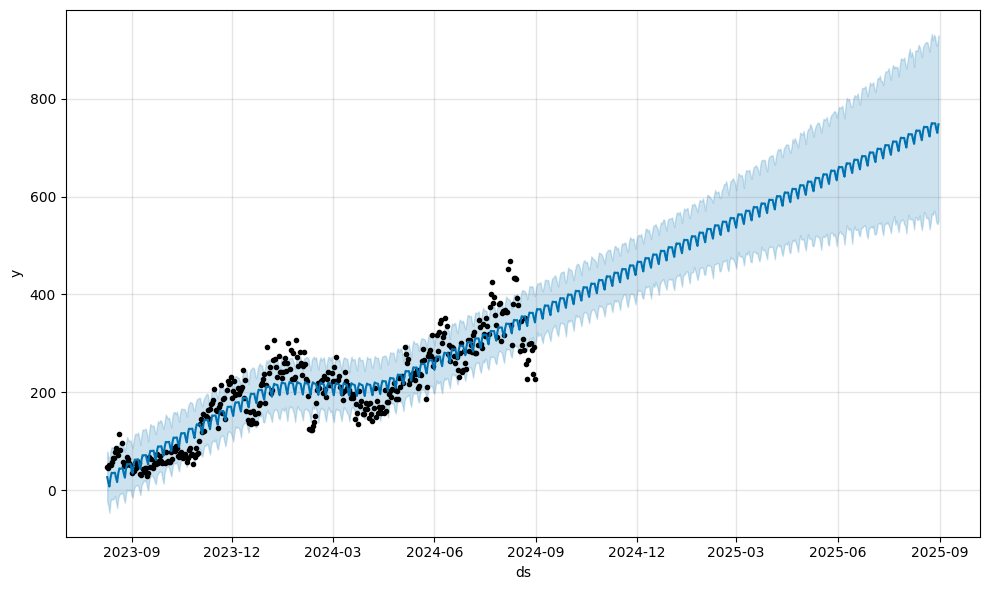

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


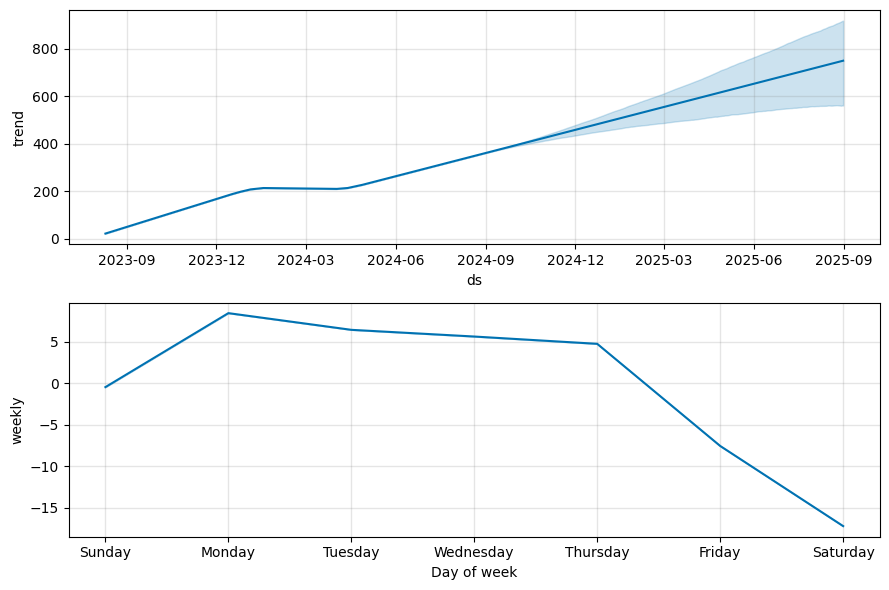

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

#### 3.3.2 - Dự đoán Lượt nhấp trong 365 ngày tiếp theo

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
# Convert to DataFrame
df01 = df.copy()

In [ ]:
df01 = df01.rename(columns={'Lượt hiển thị': 'Impressions', 'Lượt nhấp': 'Clicks', 'Vị trí':'Position','Click Through Rate':'CTR'})

In [ ]:
df01 = df01.drop(columns=["Impressions","CTR","Position"])
df01.head(5)

,Ngày,Clicks
0,2024-08-31,7
1,2024-08-30,9
2,2024-08-29,9
3,2024-08-28,9
4,2024-08-27,5


In [ ]:
df01.rename(columns={'Ngày': 'ds', 'Clicks': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df01['ds'] = pd.to_datetime(df00['ds'])

In [ ]:
df01.head()

,ds,y
0,2024-08-31,7
1,2024-08-30,9
2,2024-08-29,9
3,2024-08-28,9
4,2024-08-27,5


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df01)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2m3kevrj/2qed28wt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2m3kevrj/zj2l_olh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77977', 'data', 'file=/tmp/tmp2m3kevrj/2qed28wt.json', 'init=/tmp/tmp2m3kevrj/zj2l_olh.json', 'output', 'file=/tmp/tmp2m3kevrj/prophet_modelpst_3rwb/prophet_model-20240912074540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


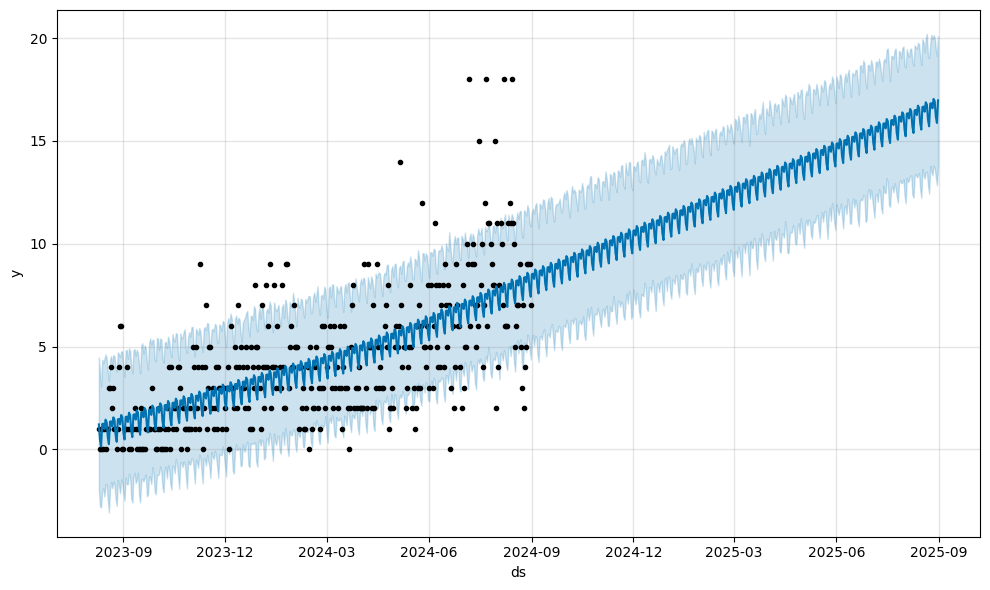

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


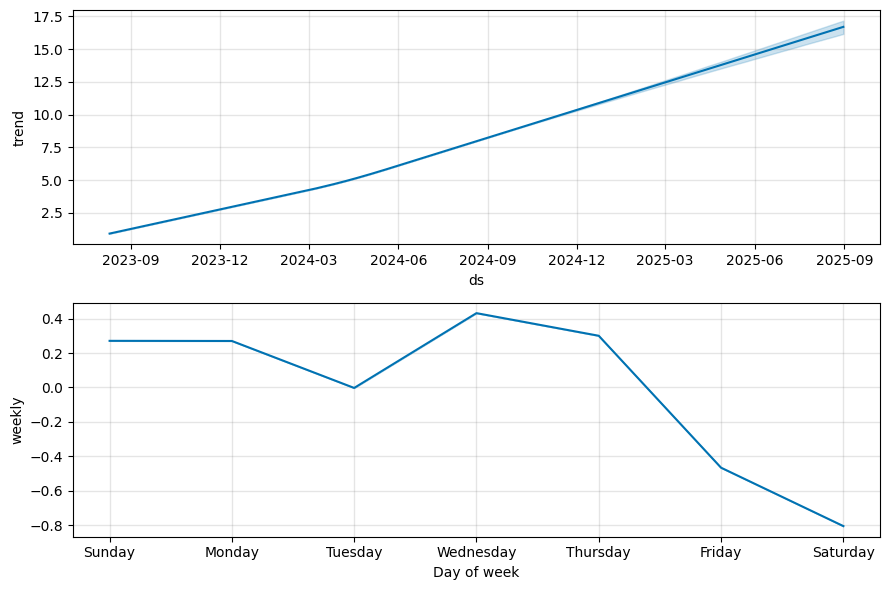

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

#### 3.3.3 - Dự đoán CTR trong 365 ngày tiếp theo

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
# Convert to DataFrame
df02 = df.copy()

In [ ]:
df02 = df02.rename(columns={'Lượt hiển thị': 'Impressions', 'Lượt nhấp': 'Clicks', 'Vị trí':'Position','Click Through Rate':'CTR'})

In [ ]:
df02 = df02.drop(columns=["Impressions","Clicks","Position"])
df02.head(5)

,Ngày,CTR
0,2024-08-31,3.070175
1,2024-08-30,3.071672
2,2024-08-29,3.781513
3,2024-08-28,3.146853
4,2024-08-27,1.661130


In [ ]:
df02.rename(columns={'Ngày': 'ds', 'CTR': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df02['ds'] = pd.to_datetime(df00['ds'])

In [ ]:
df02.head()

,ds,y
0,2024-08-31,3.070175
1,2024-08-30,3.071672
2,2024-08-29,3.781513
3,2024-08-28,3.146853
4,2024-08-27,1.661130


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df02)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2m3kevrj/3os4t6uj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2m3kevrj/0mopkshn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99418', 'data', 'file=/tmp/tmp2m3kevrj/3os4t6uj.json', 'init=/tmp/tmp2m3kevrj/0mopkshn.json', 'output', 'file=/tmp/tmp2m3kevrj/prophet_model5gyt607_/prophet_model-20240912074641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


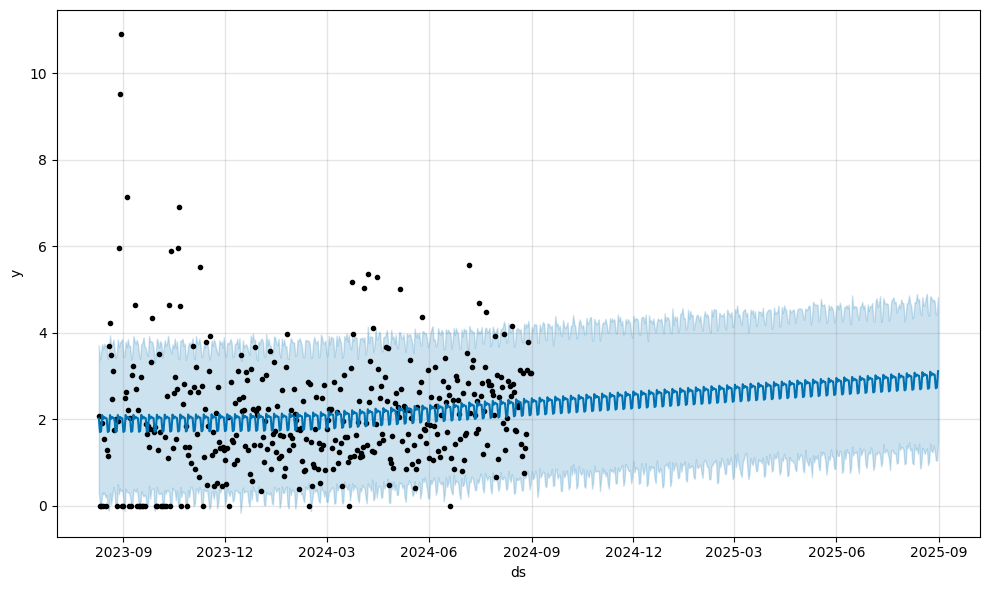

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


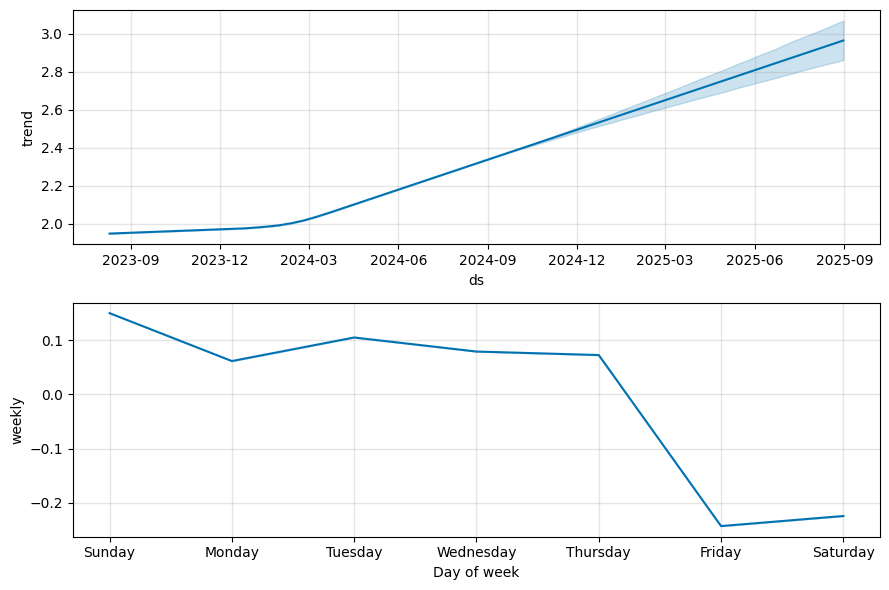

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

# B - Forecast on Demart GA4 Data (All Traffic)

## 1 - Import Packages

In [ ]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols

# For saving models
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Link Download Dataset: Xem ở trong Github: https://github.com/NghiaNT3110/traffic_gsc_ga_8

In [ ]:
df = pd.read_csv('/content/GA4_Data.csv')

In [ ]:
df["Engagement Rate"] = df["Engaged sessions"] / df["Sessions"] * 100
df["% New User"] = df["New users"] / df["Total users"] * 100
df["View per User"] = df["Views"] / df["Total users"]
df["View per Session"] = df["Views"] / df["Sessions"]
df["Event per User"] = df["Event count"] / df["Total users"]
df["Event per Session"] = df["Event count"] / df["Sessions"]

# Convert cột Average Time per Session từ String thành Float

df.head(5)

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
df.describe()

,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,31.093506,11.368831,8.763636,13.103896,8.750649,32.167942,258.007792,1.080519,66.264154,75.528925,2.946283,2.361772,24.900272,20.024602
std,27.598905,7.391864,6.524292,8.282739,5.963444,26.538479,223.082320,3.155065,18.683924,18.237276,2.610014,1.626367,22.479849,13.844284
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.100000,0.100000,6.500000,4.333333
25%,13.000000,7.000000,4.000000,7.000000,4.000000,15.125000,110.000000,0.000000,56.521739,66.666667,1.500000,1.400000,12.857143,11.764706
50%,24.000000,10.000000,7.000000,12.000000,8.000000,25.818182,200.000000,0.000000,68.421053,78.571429,2.071429,1.911765,17.857143,15.648649
75%,41.000000,15.000000,11.000000,17.000000,11.000000,40.318182,337.000000,0.000000,77.777778,87.500000,3.312500,2.789474,28.000000,23.200000
max,190.000000,47.000000,44.000000,60.000000,42.000000,173.555556,1514.000000,36.000000,100.000000,133.333333,19.500000,11.812500,192.500000,94.625000


1 số thông tin thống kê về các chỉ số trên Website:
*   Trung bình 1 ngày Website có 31 lượt View, Thời gian tương tác trung bình trên phiên (Session) là 32 giây
*   Trung bình 1 ngày Website có 11 User vào Website, 13 phiên trên Website, % New User là 75.52%
*   Tỷ lệ tương tác trung bình (Engagement Rate) của User là 66.26% (Bounce Rate được tính trên GA4 = 100% - Engagement Rate)
*   1 User trung bình xem 2 lượt/trang và 2 lượt/phiên, tương tác tổng với 24 event rồi mới thoát Website
*   1 User trung bình tương tác với 20 event trong 1 phiên


## 2 - EDA

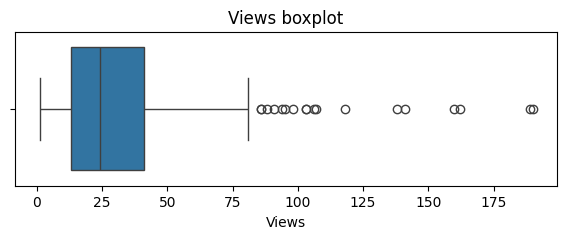

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Views'])
plt.title('Views boxplot')
plt.show()

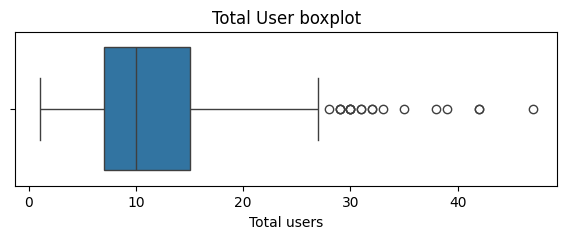

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Total users'])
plt.title('Total User boxplot')
plt.show()

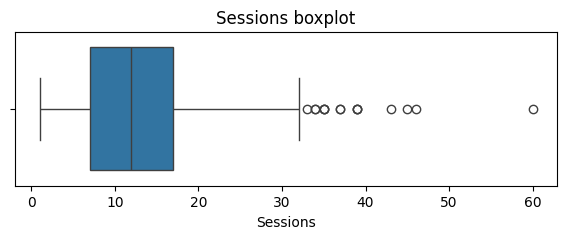

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Sessions'])
plt.title('Sessions boxplot')
plt.show()

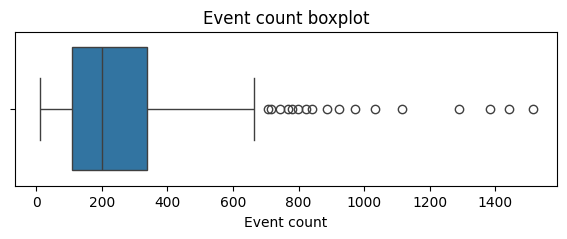

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Event count'])
plt.title('Event count boxplot')
plt.show()

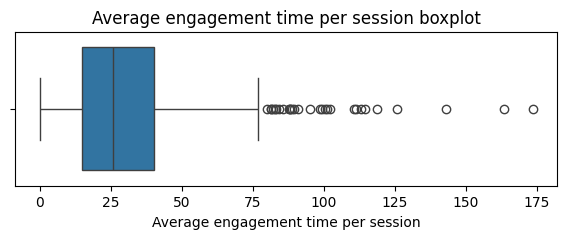

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Average engagement time per session'])
plt.title('Average engagement time per session boxplot')
plt.show()

Note: Các Outlier đều nằm về bên phải, có thể cho rằng khi Traffic tăng thì các Metrics khác tăng theo, sẽ vẽ thêm Correlation Matrix ở dưới để tìm hiểu thêm về xu hướng này

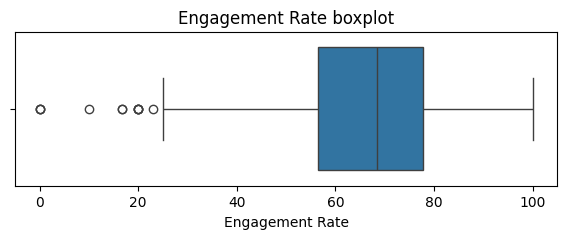

In [ ]:
# Box plot
plt.figure(figsize=(7,2))
ax = sns.boxplot(x = df['Engagement Rate'])
plt.title('Engagement Rate boxplot')
plt.show()

Outlier ở đồ thị này nằm về bên trái, có thể cho rằng Engagement Rate thấp khi Traffic sụt giảm

In [ ]:
# Bỏ các cột phụ để check độ tương quan giữa các biến chính
df1 = df.drop(columns=["Date","% New User","View per User","View per Session","Event per User","Event per Session"])
df1.head()

,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate
0,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000
1,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000
2,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778
3,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588
4,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769


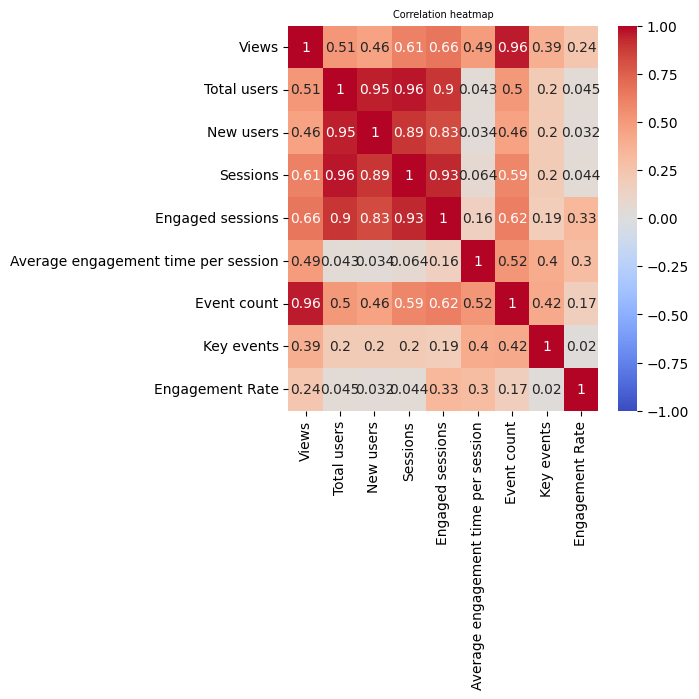

In [ ]:
# Calculate correlation and plot heatmap
plt.figure(figsize=(5,5))
corr_matrix = df1.corr(method='pearson')
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap', fontsize=7)
plt.show()

Ta có thể thấy các chỉ số chính đều có MQH tương quan dương, 1 số MQH đặc biệt tương quan cao mà ta có thể để ý đó là giữa User và Session, giữa Engaged Session, Total Session, Average Session Time và Event Count

Từ đó, ta hiểu rằng nếu như Traffic có dấu hiệu suy giảm thì các Metrics cũng sẽ giảm theo

## 3 - Xây dựng mô hình hồi quy

### 3.1 - Xây dựng mô hình hồi quy cho biến Total User

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df2 = df.copy()
df2.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df2['Total users']
print(y)

0      47.0
1      10.0
2      12.0
3      11.0
4      13.0
       ... 
987     NaN
988     NaN
989     NaN
990     NaN
991     NaN
Name: Total users, Length: 992, dtype: float64


In [ ]:
x=df2.drop(columns=["Total users"])
print(x)

           Date  Views  New users  Sessions  Engaged sessions  \
0    2023-10-21  190.0       44.0      60.0              42.0   
1    2024-01-08  189.0        7.0      16.0              14.0   
2    2023-12-19  162.0        8.0      18.0              14.0   
3    2023-12-26  160.0        6.0      17.0              13.0   
4    2024-05-03  141.0       11.0      13.0               9.0   
..          ...    ...        ...       ...               ...   
987          --    NaN        NaN       NaN               NaN   
988          --    NaN        NaN       NaN               NaN   
989          --    NaN        NaN       NaN               NaN   
990          --    NaN        NaN       NaN               NaN   
991          --    NaN        NaN       NaN               NaN   

     Average engagement time per session  Event count  Key events  \
0                              67.283333       1441.0         9.0   
1                              67.937500       1514.0         0.0   
2           

In [ ]:
GSC_X = df2[["Views", "Sessions", "Engaged sessions", "Average engagement time per session", "Event count", "Key events","Engagement Rate"]]
GSC_Y = df2[["Total users"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df2.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Total_users ~ Views + Sessions + Engaged_sessions + AVG_time_per_sessions + Event_count + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_users   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     867.9
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          4.21e-228
Time:                        02:36:43   Log-Likelihood:                -769.26
No. Observations:                 385   AIC:                             1555.
Df Residuals:                     377   BIC:                             1586.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3935      0.590     -0.667      0.505      -1.553       0.766
Views                    -0.0454      0.013     -3.528      0.000      -0.071      -0.020
Sessions                  0.9114      0.051     17.803      0.000       0.811       1.012
Engaged_sessions          0.0522      0.076      0.683      0.495      -0.098       0.202
AVG_time_per_sessions     0.0104      0.005      2.245      0.025       0.001       0.020
Event_count              -0.0002      0.002     -0.126      0.900      -0.003       0.003
Key_events                0.0843      0.033      2.517      0.012       0.018       0.150
Engagement_Rate           0.0060      0.009      0.693      0.489      -0.011       0.023
==============================================================================
Omnibus:                       92.789   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.820
Skew:                          -1.087   Prob(JB):                     3.17e-63
Kurtosis:                       6.635   Cond. No.                     2.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến Event Count có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Total_users ~ Views + Sessions + Engaged_sessions + AVG_time_per_sessions + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_users   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1015.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          1.28e-229
Time:                        02:36:59   Log-Likelihood:                -769.26
No. Observations:                 385   AIC:                             1553.
Df Residuals:                     378   BIC:                             1580.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4028      0.585     -0.689      0.491      -1.552       0.747
Views                    -0.0469      0.005     -8.810      0.000      -0.057      -0.036
Sessions                  0.9111      0.051     17.839      0.000       0.811       1.011
Engaged_sessions          0.0523      0.076      0.687      0.493      -0.098       0.202
AVG_time_per_sessions     0.0103      0.004      2.293      0.022       0.001       0.019
Key_events                0.0839      0.033      2.520      0.012       0.018       0.149
Engagement_Rate           0.0062      0.009      0.720      0.472      -0.011       0.023
==============================================================================
Omnibus:                       92.120   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.536
Skew:                          -1.079   Prob(JB):                     9.92e-63
Kurtosis:                       6.625   Cond. No.                         554.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Biến Engagement Rate có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Total_users ~ Views + Sessions + Engaged_sessions + AVG_time_per_sessions + Key_events"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_users   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1220.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          4.51e-231
Time:                        02:38:00   Log-Likelihood:                -769.53
No. Observations:                 385   AIC:                             1551.
Df Residuals:                     379   BIC:                             1575.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0101      0.211     -0.048      0.962      -0.425       0.404
Views                    -0.0471      0.005     -8.876      0.000      -0.058      -0.037
Sessions                  0.8829      0.033     26.943      0.000       0.818       0.947
Engaged_sessions          0.0958      0.047      2.058      0.040       0.004       0.187
AVG_time_per_sessions     0.0107      0.004      2.420      0.016       0.002       0.019
Key_events                0.0836      0.033      2.512      0.012       0.018       0.149
==============================================================================
Omnibus:                       90.507   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.248
Skew:                          -1.059   Prob(JB):                     8.47e-62
Kurtosis:                       6.612   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương cao và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình có dạng: Total_users = 	-0.0101	- 0.0471 * Views + 0.8829 * Sessions + 0.0958 * Engaged_sessions + 0.0107 * AVG_time_per_sessions + 0.0836 * Key_events

### 3.2 - Xây dựng mô hình hồi quy cho biến Views

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df3 = df.copy()
df3.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df3['Views']
print(y)

0      190.0
1      189.0
2      162.0
3      160.0
4      141.0
       ...  
987      NaN
988      NaN
989      NaN
990      NaN
991      NaN
Name: Views, Length: 992, dtype: float64


In [ ]:
x=df3.drop(columns=["Views"])
print(x)

           Date  Total users  New users  Sessions  Engaged sessions  \
0    2023-10-21         47.0       44.0      60.0              42.0   
1    2024-01-08         10.0        7.0      16.0              14.0   
2    2023-12-19         12.0        8.0      18.0              14.0   
3    2023-12-26         11.0        6.0      17.0              13.0   
4    2024-05-03         13.0       11.0      13.0               9.0   
..          ...          ...        ...       ...               ...   
987          --          NaN        NaN       NaN               NaN   
988          --          NaN        NaN       NaN               NaN   
989          --          NaN        NaN       NaN               NaN   
990          --          NaN        NaN       NaN               NaN   
991          --          NaN        NaN       NaN               NaN   

     Average engagement time per session  Event count  Key events  \
0                              67.283333       1441.0         9.0   
1        

In [ ]:
GSC_X = df3[["Total users", "Sessions", "Engaged sessions", "Average engagement time per session", "Event count", "Key events","Engagement Rate"]]
GSC_Y = df3[["Views"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df3.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Views ~ Total_users + Sessions + Engaged_sessions + AVG_time_per_sessions + Event_count + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Views   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     774.2
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          2.44e-219
Time:                        02:39:05   Log-Likelihood:                -1297.1
No. Observations:                 385   AIC:                             2610.
Df Residuals:                     377   BIC:                             2642.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.3548      2.309     -2.319      0.021      -9.895      -0.815
Total_users              -0.7042      0.200     -3.528      0.000      -1.097      -0.312
Sessions                  0.4974      0.272      1.826      0.069      -0.038       1.033
Engaged_sessions          0.5712      0.299      1.908      0.057      -0.017       1.160
AVG_time_per_sessions    -0.0119      0.018     -0.647      0.518      -0.048       0.024
Event_count               0.1097      0.003     38.831      0.000       0.104       0.115
Key_events                0.0189      0.133      0.142      0.887      -0.243       0.281
Engagement_Rate           0.0755      0.034      2.217      0.027       0.009       0.143
==============================================================================
Omnibus:                       97.091   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3190.437
Skew:                          -0.162   Prob(JB):                         0.00
Kurtosis:                      17.099   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến Key Event Count có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Views ~ Total_users + Sessions + Engaged_sessions + AVG_time_per_sessions + Event_count + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Views   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     905.6
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          7.86e-221
Time:                        02:45:19   Log-Likelihood:                -1297.1
No. Observations:                 385   AIC:                             2608.
Df Residuals:                     378   BIC:                             2636.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.3756      2.301     -2.336      0.020      -9.900      -0.851
Total_users              -0.7005      0.198     -3.544      0.000      -1.089      -0.312
Sessions                  0.4967      0.272      1.826      0.069      -0.038       1.032
Engaged_sessions          0.5672      0.298      1.905      0.057      -0.018       1.152
AVG_time_per_sessions    -0.0113      0.018     -0.632      0.528      -0.047       0.024
Event_count               0.1098      0.003     40.066      0.000       0.104       0.115
Engagement_Rate           0.0755      0.034      2.219      0.027       0.009       0.142
==============================================================================
Omnibus:                       97.162   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3204.656
Skew:                          -0.161   Prob(JB):                         0.00
Kurtosis:                      17.130   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến AVG_time_per_sessions và Sessions có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Views ~ Total_users + Engaged_sessions + Event_count + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Views   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1797.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          2.08e-224
Time:                        02:41:07   Log-Likelihood:                -1299.9
No. Observations:                 385   AIC:                             2608.
Df Residuals:                     381   BIC:                             2624.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6567      0.686     -0.958      0.339      -2.005       0.692
Total_users         -0.5748      0.113     -5.068      0.000      -0.798      -0.352
Engaged_sessions     1.1545      0.155      7.435      0.000       0.849       1.460
Event_count          0.1092      0.002     51.841      0.000       0.105       0.113
==============================================================================
Omnibus:                       97.039   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3028.382
Skew:                          -0.211   Prob(JB):                         0.00
Kurtosis:                      16.733   Cond. No.                         646.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Biến Engagement Rate có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Views ~ Total_users + Engaged_sessions + Event_count "

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Views   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1797.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          2.08e-224
Time:                        02:42:22   Log-Likelihood:                -1299.9
No. Observations:                 385   AIC:                             2608.
Df Residuals:                     381   BIC:                             2624.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6567      0.686     -0.958      0.339      -2.005       0.692
Total_users         -0.5748      0.113     -5.068      0.000      -0.798      -0.352
Engaged_sessions     1.1545      0.155      7.435      0.000       0.849       1.460
Event_count          0.1092      0.002     51.841      0.000       0.105       0.113
==============================================================================
Omnibus:                       97.039   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3028.382
Skew:                          -0.211   Prob(JB):                         0.00
Kurtosis:                      16.733   Cond. No.                         646.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương cao và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: Views = -0.6567 -0.5748 * Total_users + 1.1545 * Engaged_sessions + 0.1092 * Event_count

### 3.3 - Xây dựng mô hình hồi quy cho biến Sessions

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df4 = df.copy()
df4.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df4['Sessions']
print(y)

0      60.0
1      16.0
2      18.0
3      17.0
4      13.0
       ... 
987     NaN
988     NaN
989     NaN
990     NaN
991     NaN
Name: Sessions, Length: 992, dtype: float64


In [ ]:
x=df4.drop(columns=["Sessions"])
print(x)

           Date  Views  Total users  New users  Engaged sessions  \
0    2023-10-21  190.0         47.0       44.0              42.0   
1    2024-01-08  189.0         10.0        7.0              14.0   
2    2023-12-19  162.0         12.0        8.0              14.0   
3    2023-12-26  160.0         11.0        6.0              13.0   
4    2024-05-03  141.0         13.0       11.0               9.0   
..          ...    ...          ...        ...               ...   
987          --    NaN          NaN        NaN               NaN   
988          --    NaN          NaN        NaN               NaN   
989          --    NaN          NaN        NaN               NaN   
990          --    NaN          NaN        NaN               NaN   
991          --    NaN          NaN        NaN               NaN   

     Average engagement time per session  Event count  Key events  \
0                              67.283333       1441.0         9.0   
1                              67.937500     

In [ ]:
GSC_X = df4[["Total users", "Views", "Engaged sessions", "Average engagement time per session", "Event count", "Key events","Engagement Rate"]]
GSC_Y = df4[["Sessions"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df4.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Sessions ~ Total_users + Views + Engaged_sessions + AVG_time_per_sessions + Event_count + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sessions   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2051.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          1.17e-295
Time:                        02:45:51   Log-Likelihood:                -654.13
No. Observations:                 385   AIC:                             1324.
Df Residuals:                     377   BIC:                             1356.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.2052      0.346     15.043      0.000       4.525       5.886
Total_users               0.5011      0.028     17.803      0.000       0.446       0.556
Views                     0.0176      0.010      1.826      0.069      -0.001       0.037
Engaged_sessions          0.7482      0.042     18.027      0.000       0.667       0.830
AVG_time_per_sessions    -0.0099      0.003     -2.886      0.004      -0.017      -0.003
Event_count               0.0009      0.001      0.747      0.455      -0.001       0.003
Key_events               -0.0086      0.025     -0.342      0.732      -0.058       0.041
Engagement_Rate          -0.0724      0.005    -13.720      0.000      -0.083      -0.062
==============================================================================
Omnibus:                       70.202   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.158
Skew:                           0.905   Prob(JB):                     1.85e-37
Kurtosis:                       5.696   Cond. No.                     1.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến Key Event Count và Event Count có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Sessions ~ Total_users + Views + Engaged_sessions + AVG_time_per_sessions "

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sessions   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2323.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          1.45e-265
Time:                        02:46:44   Log-Likelihood:                -736.63
No. Observations:                 385   AIC:                             1483.
Df Residuals:                     380   BIC:                             1503.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.9423      0.184      5.132      0.000       0.581       1.303
Total_users               0.7437      0.027     27.597      0.000       0.691       0.797
Views                     0.0400      0.005      8.340      0.000       0.031       0.049
Engaged_sessions          0.3631      0.038      9.591      0.000       0.289       0.438
AVG_time_per_sessions    -0.0222      0.004     -5.870      0.000      -0.030      -0.015
==============================================================================
Omnibus:                       75.353   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.304
Skew:                           1.027   Prob(JB):                     6.95e-35
Kurtosis:                       5.363   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương cao và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: Sessions = 0.9423 + 0.7437 * Total_users + 0.04 * Views + 0.3631 * Engaged_sessions - 0.0222 * AVG_time_per_sessions

### 3.4 - Xây dựng mô hình hồi quy cho biến Engaged sessions

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df5 = df.copy()
df5.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df5['Engaged sessions']
print(y)

0      42.0
1      14.0
2      14.0
3      13.0
4       9.0
       ... 
987     NaN
988     NaN
989     NaN
990     NaN
991     NaN
Name: Engaged sessions, Length: 992, dtype: float64


In [ ]:
x=df5.drop(columns=["Engaged sessions"])
print(x)

           Date  Views  Total users  New users  Sessions  \
0    2023-10-21  190.0         47.0       44.0      60.0   
1    2024-01-08  189.0         10.0        7.0      16.0   
2    2023-12-19  162.0         12.0        8.0      18.0   
3    2023-12-26  160.0         11.0        6.0      17.0   
4    2024-05-03  141.0         13.0       11.0      13.0   
..          ...    ...          ...        ...       ...   
987          --    NaN          NaN        NaN       NaN   
988          --    NaN          NaN        NaN       NaN   
989          --    NaN          NaN        NaN       NaN   
990          --    NaN          NaN        NaN       NaN   
991          --    NaN          NaN        NaN       NaN   

     Average engagement time per session  Event count  Key events  \
0                              67.283333       1441.0         9.0   
1                              67.937500       1514.0         0.0   
2                              80.111111       1290.0         0.0   
3  

In [ ]:
GSC_X = df5[["Total users", "Views", "Sessions", "Average engagement time per session", "Event count", "Key events","Engagement Rate"]]
GSC_Y = df5[["Engaged sessions"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df5.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Engaged_sessions ~ Total_users + Views + Sessions + AVG_time_per_sessions + Event_count + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Engaged_sessions   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1265.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          2.00e-257
Time:                        02:58:53   Log-Likelihood:                -617.58
No. Observations:                 385   AIC:                             1251.
Df Residuals:                     377   BIC:                             1283.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.8677      0.259    -22.645      0.000      -6.377      -5.358
Total_users               0.0237      0.035      0.683      0.495      -0.045       0.092
Views                     0.0167      0.009      1.908      0.057      -0.001       0.034
Sessions                  0.6188      0.034     18.027      0.000       0.551       0.686
AVG_time_per_sessions    -0.0004      0.003     -0.130      0.897      -0.007       0.006
Event_count              -0.0004      0.001     -0.356      0.722      -0.003       0.002
Key_events               -0.0418      0.023     -1.844      0.066      -0.086       0.003
Engagement_Rate           0.0887      0.004     24.034      0.000       0.081       0.096
==============================================================================
Omnibus:                       79.788   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              847.430
Skew:                          -0.496   Prob(JB):                    9.61e-185
Kurtosis:                      10.200   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến Event Count và AVG time per Sessions có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Engaged_sessions ~ Total_users + Views + Sessions  + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Engaged_sessions   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1780.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          1.23e-260
Time:                        02:58:59   Log-Likelihood:                -617.67
No. Observations:                 385   AIC:                             1247.
Df Residuals:                     379   BIC:                             1271.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.8950      0.250    -23.549      0.000      -6.387      -5.403
Total_users         0.0229      0.034      0.665      0.506      -0.045       0.090
Views               0.0135      0.003      3.940      0.000       0.007       0.020
Sessions            0.6200      0.033     18.509      0.000       0.554       0.686
Key_events         -0.0440      0.022     -2.030      0.043      -0.087      -0.001
Engagement_Rate     0.0889      0.003     25.515      0.000       0.082       0.096
==============================================================================
Omnibus:                       79.084   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.715
Skew:                          -0.487   Prob(JB):                    1.24e-182
Kurtosis:                      10.161   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Biến Total User có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Engaged_sessions ~  Views + Sessions  + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Engaged_sessions   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2228.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          3.04e-262
Time:                        03:01:02   Log-Likelihood:                -617.90
No. Observations:                 385   AIC:                             1246.
Df Residuals:                     380   BIC:                             1266.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.9089      0.249    -23.705      0.000      -6.399      -5.419
Views               0.0126      0.003      4.022      0.000       0.006       0.019
Sessions            0.6413      0.010     67.308      0.000       0.623       0.660
Key_events         -0.0417      0.021     -1.949      0.052      -0.084       0.000
Engagement_Rate     0.0892      0.003     25.854      0.000       0.082       0.096
==============================================================================
Omnibus:                       77.060   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              796.810
Skew:                          -0.469   Prob(JB):                    9.44e-174
Kurtosis:                       9.985   Cond. No.                         314.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Biến Key Event có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Engaged_sessions ~  Views + Sessions + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Engaged_sessions   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     2948.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          3.42e-263
Time:                        03:02:16   Log-Likelihood:                -619.81
No. Observations:                 385   AIC:                             1248.
Df Residuals:                     381   BIC:                             1263.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.9403      0.250    -23.793      0.000      -6.431      -5.449
Views               0.0105      0.003      3.552      0.000       0.005       0.016
Sessions            0.6424      0.010     67.298      0.000       0.624       0.661
Engagement_Rate     0.0898      0.003     26.024      0.000       0.083       0.097
==============================================================================
Omnibus:                       78.451   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              824.045
Skew:                          -0.482   Prob(JB):                    1.15e-179
Kurtosis:                      10.102   Cond. No.                         314.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương cao và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: Engaged_sessions	 = -5.9403 + 0.0105 * Views + 0.6424 * Sessions + 0.0898 * Engagement_Rate

### 3.5 - Xây dựng mô hình hồi quy cho biến Average engagement time per session

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df6 = df.copy()
df6.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df6['Average engagement time per session']
print(y)

0      67.283333
1      67.937500
2      80.111111
3      95.117647
4      64.307692
         ...    
987          NaN
988          NaN
989          NaN
990          NaN
991          NaN
Name: Average engagement time per session, Length: 992, dtype: float64


In [ ]:
x=df6.drop(columns=["Average engagement time per session"])
print(x)

           Date  Views  Total users  New users  Sessions  Engaged sessions  \
0    2023-10-21  190.0         47.0       44.0      60.0              42.0   
1    2024-01-08  189.0         10.0        7.0      16.0              14.0   
2    2023-12-19  162.0         12.0        8.0      18.0              14.0   
3    2023-12-26  160.0         11.0        6.0      17.0              13.0   
4    2024-05-03  141.0         13.0       11.0      13.0               9.0   
..          ...    ...          ...        ...       ...               ...   
987          --    NaN          NaN        NaN       NaN               NaN   
988          --    NaN          NaN        NaN       NaN               NaN   
989          --    NaN          NaN        NaN       NaN               NaN   
990          --    NaN          NaN        NaN       NaN               NaN   
991          --    NaN          NaN        NaN       NaN               NaN   

     Event count  Key events  Engagement Rate  % New User  View

In [ ]:
GSC_X = df6[["Total users", "Views", "Sessions", "Engaged sessions", "Event count", "Key events","Engagement Rate"]]
GSC_Y = df6[["Average engagement time per session"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df6.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "AVG_time_per_sessions ~ Total_users + Views + Sessions + Engaged_sessions + Event_count + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     AVG_time_per_sessions   R-squared:                       0.452
Model:                               OLS   Adj. R-squared:                  0.442
Method:                    Least Squares   F-statistic:                     44.40
Date:                   Thu, 12 Sep 2024   Prob (F-statistic):           1.25e-45
Time:                           03:07:35   Log-Likelihood:                -1692.3
No. Observations:                    385   AIC:                             3401.
Df Residuals:                        377   BIC:                             3432.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.1813      6.485      0.799      0.425      -7.570      17.933
Total_users          1.2632      0.563      2.245      0.025       0.157       2.369
Views               -0.0929      0.144     -0.647      0.518      -0.375       0.190
Sessions            -2.1804      0.755     -2.886      0.004      -3.666      -0.695
Engaged_sessions    -0.1091      0.840     -0.130      0.897      -1.760       1.542
Event_count          0.0880      0.017      5.163      0.000       0.054       0.121
Key_events           1.6541      0.361      4.576      0.000       0.943       2.365
Engagement_Rate      0.3103      0.094      3.286      0.001       0.125       0.496
==============================================================================
Omnibus:                      200.334   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1602.113
Skew:                           2.064   Prob(JB):                         0.00
Kurtosis:                      12.101   Cond. No.                     2.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến Engaged Sessions và View có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "AVG_time_per_sessions ~ Total_users + Sessions + Event_count + Key_events + Engagement_Rate"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     AVG_time_per_sessions   R-squared:                       0.451
Model:                               OLS   Adj. R-squared:                  0.444
Method:                    Least Squares   F-statistic:                     62.33
Date:                   Thu, 12 Sep 2024   Prob (F-statistic):           2.50e-47
Time:                           03:09:12   Log-Likelihood:                -1692.5
No. Observations:                    385   AIC:                             3397.
Df Residuals:                        379   BIC:                             3421.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.6624      4.011      1.661      0.097      -1.223      14.548
Total_users         1.3283      0.552      2.407      0.017       0.243       2.413
Sessions           -2.3321      0.532     -4.387      0.000      -3.377      -1.287
Event_count         0.0776      0.007     11.636      0.000       0.065       0.091
Key_events          1.6612      0.359      4.628      0.000       0.955       2.367
Engagement_Rate     0.2889      0.055      5.226      0.000       0.180       0.398
==============================================================================
Omnibus:                      200.265   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1610.960
Skew:                           2.060   Prob(JB):                         0.00
Kurtosis:                      12.135   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Mô hình có R bình phương thấp (<0.5) nên chư đủ ý nghĩa thống kê và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: AVG_time_per_sessions = 6.6624 + 1.3283 * Total_users -2.3321 * Sessions + 0.0776 * Event_count + 1.6612 * Key_events + 0.2889 * Engagement_Rate

### 3.6 - Xây dựng mô hình hồi quy cho biến Engagement Rate

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df7 = df.copy()
df7.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df7['Engagement Rate']
print(y)

0      70.000000
1      87.500000
2      77.777778
3      76.470588
4      69.230769
         ...    
987          NaN
988          NaN
989          NaN
990          NaN
991          NaN
Name: Engagement Rate, Length: 992, dtype: float64


In [ ]:
x=df7.drop(columns=["Engagement Rate"])
print(x)

           Date  Views  Total users  New users  Sessions  Engaged sessions  \
0    2023-10-21  190.0         47.0       44.0      60.0              42.0   
1    2024-01-08  189.0         10.0        7.0      16.0              14.0   
2    2023-12-19  162.0         12.0        8.0      18.0              14.0   
3    2023-12-26  160.0         11.0        6.0      17.0              13.0   
4    2024-05-03  141.0         13.0       11.0      13.0               9.0   
..          ...    ...          ...        ...       ...               ...   
987          --    NaN          NaN        NaN       NaN               NaN   
988          --    NaN          NaN        NaN       NaN               NaN   
989          --    NaN          NaN        NaN       NaN               NaN   
990          --    NaN          NaN        NaN       NaN               NaN   
991          --    NaN          NaN        NaN       NaN               NaN   

     Average engagement time per session  Event count  Key even

In [ ]:
GSC_X = df7[["Total users", "Views", "Sessions", "Engaged sessions", "Event count", "Key events","Average engagement time per session"]]
GSC_Y = df7[["Engagement Rate"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df7.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Engagement_Rate ~ Total_users + Views + Sessions + Engaged_sessions + Event_count + Key_events + AVG_time_per_sessions"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Engagement_Rate   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     114.5
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           2.93e-89
Time:                        03:21:27   Log-Likelihood:                -1453.6
No. Observations:                 385   AIC:                             2923.
Df Residuals:                     377   BIC:                             2955.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                63.2957      1.250     50.641      0.000      60.838      65.753
Total_users               0.2109      0.304      0.693      0.489      -0.388       0.810
Views                     0.1703      0.077      2.217      0.027       0.019       0.321
Sessions                 -4.6029      0.335    -13.720      0.000      -5.263      -3.943
Engaged_sessions          6.8222      0.284     24.034      0.000       6.264       7.380
Event_count              -0.0271      0.009     -2.885      0.004      -0.046      -0.009
Key_events               -0.0127      0.200     -0.064      0.949      -0.406       0.380
AVG_time_per_sessions     0.0898      0.027      3.286      0.001       0.036       0.143
==============================================================================
Omnibus:                       57.119   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.933
Skew:                          -0.280   Prob(JB):                     3.28e-98
Kurtosis:                       8.260   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Biến Key Event và Total User có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Engagement_Rate ~  Views + Sessions + Engaged_sessions + Event_count + AVG_time_per_sessions"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Engagement_Rate   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     160.8
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           2.31e-91
Time:                        03:22:52   Log-Likelihood:                -1453.8
No. Observations:                 385   AIC:                             2920.
Df Residuals:                     379   BIC:                             2943.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                63.2874      1.226     51.609      0.000      60.876      65.699
Views                     0.1609      0.075      2.132      0.034       0.013       0.309
Sessions                 -4.4156      0.198    -22.345      0.000      -4.804      -4.027
Engaged_sessions          6.8409      0.279     24.524      0.000       6.292       7.389
Event_count              -0.0271      0.009     -2.912      0.004      -0.045      -0.009
AVG_time_per_sessions     0.0923      0.026      3.524      0.000       0.041       0.144
==============================================================================
Omnibus:                       57.209   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.663
Skew:                          -0.276   Prob(JB):                     3.08e-99
Kurtosis:                       8.289   Cond. No.                         783.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương chấp nhận được (>0.5) nên có ý nghĩa thống kê và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: Engagement_Rate = 63.2874 + 0.1609 * Views -4.4156 * Sessions + 6.8409 * Engaged_sessions -0.0271 * Event_count + 0.0923 * AVG_time_per_sessions

### 3.7 - Xây dựng mô hình hồi quy cho biến Event Count

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df8 = df.copy()
df8.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df8['Event count']
print(y)

0      1441.0
1      1514.0
2      1290.0
3      1384.0
4       781.0
        ...  
987       NaN
988       NaN
989       NaN
990       NaN
991       NaN
Name: Event count, Length: 992, dtype: float64


In [ ]:
x=df8.drop(columns=["Event count"])
print(x)

           Date  Views  Total users  New users  Sessions  Engaged sessions  \
0    2023-10-21  190.0         47.0       44.0      60.0              42.0   
1    2024-01-08  189.0         10.0        7.0      16.0              14.0   
2    2023-12-19  162.0         12.0        8.0      18.0              14.0   
3    2023-12-26  160.0         11.0        6.0      17.0              13.0   
4    2024-05-03  141.0         13.0       11.0      13.0               9.0   
..          ...    ...          ...        ...       ...               ...   
987          --    NaN          NaN        NaN       NaN               NaN   
988          --    NaN          NaN        NaN       NaN               NaN   
989          --    NaN          NaN        NaN       NaN               NaN   
990          --    NaN          NaN        NaN       NaN               NaN   
991          --    NaN          NaN        NaN       NaN               NaN   

     Average engagement time per session  Key events  Engagemen

In [ ]:
GSC_X = df8[["Total users", "Views", "Sessions", "Engaged sessions", "Engagement Rate", "Key events","Average engagement time per session"]]
GSC_Y = df8[["Event count"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df8.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Event_count ~ Total_users + Views + Sessions + Engaged_sessions + Engagement_Rate + Key_events + AVG_time_per_sessions"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Event_count   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     759.6
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          7.06e-218
Time:                        03:29:08   Log-Likelihood:                -2105.1
No. Observations:                 385   AIC:                             4226.
Df Residuals:                     377   BIC:                             4258.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                45.8579     18.816      2.437      0.015       8.861      82.855
Total_users              -0.2090      1.655     -0.126      0.900      -3.462       3.044
Views                     7.2944      0.188     38.831      0.000       6.925       7.664
Sessions                  1.6659      2.230      0.747      0.455      -2.718       6.050
Engaged_sessions         -0.8732      2.453     -0.356      0.722      -5.697       3.950
Engagement_Rate          -0.7983      0.277     -2.885      0.004      -1.342      -0.254
Key_events                2.1036      1.080      1.948      0.052      -0.019       4.226
AVG_time_per_sessions     0.7509      0.145      5.163      0.000       0.465       1.037
==============================================================================
Omnibus:                      203.957   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2997.195
Skew:                           1.875   Prob(JB):                         0.00
Kurtosis:                      16.144   Cond. No.                         559.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Biến Engaged Session, Sessions và Total User có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Event_count ~  Views + Engagement_Rate + Key_events + AVG_time_per_sessions"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Event_count   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1326.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):          1.10e-221
Time:                        03:30:34   Log-Likelihood:                -2107.0
No. Observations:                 385   AIC:                             4224.
Df Residuals:                     380   BIC:                             4244.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                60.5062     10.951      5.525      0.000      38.975      82.038
Views                     7.4999      0.128     58.659      0.000       7.248       7.751
Engagement_Rate          -0.8959      0.169     -5.305      0.000      -1.228      -0.564
Key_events                2.1973      1.066      2.061      0.040       0.101       4.294
AVG_time_per_sessions     0.6620      0.137      4.832      0.000       0.393       0.931
==============================================================================
Omnibus:                      194.002   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3068.334
Skew:                           1.723   Prob(JB):                         0.00
Kurtosis:                      16.394   Cond. No.                         314.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương cao và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: Event_count = 60.5062 + 7.4999 * Views -0.8959 * Engagement_Rate + 2.1973 * Key_events + 0.6620 * AVG_time_per_sessions

### 3.8 - Xây dựng mô hình hồi quy cho biến Key Event

In [ ]:
# Tạo bản sao dataset dùng để xây dựng mô hình
df9 = df.copy()
df9.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events,Engagement Rate,% New User,View per User,View per Session,Event per User,Event per Session
0,2023-10-21,190.0,47.0,44.0,60.0,42.0,67.283333,1441.0,9.0,70.000000,93.617021,4.042553,3.166667,30.659574,24.016667
1,2024-01-08,189.0,10.0,7.0,16.0,14.0,67.937500,1514.0,0.0,87.500000,70.000000,18.900000,11.812500,151.400000,94.625000
2,2023-12-19,162.0,12.0,8.0,18.0,14.0,80.111111,1290.0,0.0,77.777778,66.666667,13.500000,9.000000,107.500000,71.666667
3,2023-12-26,160.0,11.0,6.0,17.0,13.0,95.117647,1384.0,10.0,76.470588,54.545455,14.545455,9.411765,125.818182,81.411765
4,2024-05-03,141.0,13.0,11.0,13.0,9.0,64.307692,781.0,6.0,69.230769,84.615385,10.846154,10.846154,60.076923,60.076923


In [ ]:
y = df9['Key events']
print(y)

0       9.0
1       0.0
2       0.0
3      10.0
4       6.0
       ... 
987     NaN
988     NaN
989     NaN
990     NaN
991     NaN
Name: Key events, Length: 992, dtype: float64


In [ ]:
x=df9.drop(columns=["Key events"])
print(x)

           Date  Views  Total users  New users  Sessions  Engaged sessions  \
0    2023-10-21  190.0         47.0       44.0      60.0              42.0   
1    2024-01-08  189.0         10.0        7.0      16.0              14.0   
2    2023-12-19  162.0         12.0        8.0      18.0              14.0   
3    2023-12-26  160.0         11.0        6.0      17.0              13.0   
4    2024-05-03  141.0         13.0       11.0      13.0               9.0   
..          ...    ...          ...        ...       ...               ...   
987          --    NaN          NaN        NaN       NaN               NaN   
988          --    NaN          NaN        NaN       NaN               NaN   
989          --    NaN          NaN        NaN       NaN               NaN   
990          --    NaN          NaN        NaN       NaN               NaN   
991          --    NaN          NaN        NaN       NaN               NaN   

     Average engagement time per session  Event count  Engageme

In [ ]:
GSC_X = df9[["Total users", "Views", "Sessions", "Engaged sessions", "Engagement Rate", "Event count","Average engagement time per session"]]
GSC_Y = df9[["Key events"]]

In [ ]:
# Perform the train-test split - train, test, validate (60%,20%,20%)
X_train, X_test, y_train, y_test = train_test_split(GSC_X, GSC_Y,
                                                    test_size = 0.3, random_state = 42)

In [ ]:
data = df9.rename(columns={'Total users': 'Total_users','Engaged sessions': 'Engaged_sessions', 'Event count': 'Event_count', 'Key events':'Key_events','Average engagement time per session':'AVG_time_per_sessions','Engagement Rate':'Engagement_Rate'})

In [ ]:
ols_formula = "Key_events ~ Total_users + Views + Sessions + Engaged_sessions + Engagement_Rate + Event_count + AVG_time_per_sessions"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Key_events   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     18.36
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           4.93e-21
Time:                        03:35:32   Log-Likelihood:                -931.69
No. Observations:                 385   AIC:                             1879.
Df Residuals:                     377   BIC:                             1911.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.0805      0.898     -1.203      0.230      -2.847       0.686
Total_users               0.1960      0.078      2.517      0.012       0.043       0.349
Views                     0.0028      0.020      0.142      0.887      -0.036       0.042
Sessions                 -0.0362      0.106     -0.342      0.732      -0.244       0.172
Engaged_sessions         -0.2138      0.116     -1.844      0.066      -0.442       0.014
Engagement_Rate          -0.0008      0.013     -0.064      0.949      -0.027       0.025
Event_count               0.0047      0.002      1.948      0.052   -4.33e-05       0.010
AVG_time_per_sessions     0.0318      0.007      4.576      0.000       0.018       0.045
==============================================================================
Omnibus:                      397.813   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25585.292
Skew:                           4.293   Prob(JB):                         0.00
Kurtosis:                      42.003   Cond. No.                     2.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Biến View, Sessions và Engagement Rate có p-value > 0.05 => Bỏ ra khỏi mô hình và vẽ lại

In [ ]:
ols_formula = "Key_events ~ Total_users + Engaged_sessions + Event_count + AVG_time_per_sessions"

In [ ]:
# Create an OLS model.

OLS = ols(formula = ols_formula, data = data)

# Fit the model.

model = OLS.fit()

# Save the results summary.

model_results = model.summary()

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Key_events   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     32.33
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           3.33e-23
Time:                        03:38:06   Log-Likelihood:                -931.77
No. Observations:                 385   AIC:                             1874.
Df Residuals:                     380   BIC:                             1893.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.1660      0.305     -3.826      0.000      -1.765      -0.567
Total_users               0.1709      0.044      3.859      0.000       0.084       0.258
Engaged_sessions         -0.2292      0.060     -3.835      0.000      -0.347      -0.112
Event_count               0.0049      0.001      5.116      0.000       0.003       0.007
AVG_time_per_sessions     0.0325      0.006      5.024      0.000       0.020       0.045
==============================================================================
Omnibus:                      401.335   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26675.493
Skew:                           4.345   Prob(JB):                         0.00
Kurtosis:                      42.842   Cond. No.                         749.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mô hình có R bình phương thấp (< 0.5) nên chưa có ý nghĩa thống kê và có các chỉ số thống kê P-value < 0.05 là có độ tin cậy thống kê.

Mô hình hồi quy có dạng: Key_events = -1.1660 + 0.1709 * Total_users -0.2292 * Engaged_sessions + 0.0049 * Event_count + 0.0325 * AVG_time_per_sessions

## 4 - Xây dựng ML

Dựa vào phần 3 - Xây dựng mô hình hồi quy, những mô hình hồi quy nào có R bình phương cao (Ở đây đang quy ước là > 0.8) sẽ được sử dụng để xây dựng ML Forecast

Ở đây ta sử dụng các biến: Total User, View, Sessions, Engaged Sessions, Event Count

### 4.1 - Dự đoán Total User

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/GA4_Data.csv')

In [ ]:
# Convert to DataFrame
df00 = df.copy()
df00.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events
0,10/21/2023,190,47,44,60,42,67.283333,1441,9
1,1/8/2024,189,10,7,16,14,67.937500,1514,0
2,12/19/2023,162,12,8,18,14,80.111111,1290,0
3,12/26/2023,160,11,6,17,13,95.117647,1384,10
4,5/3/2024,141,13,11,13,9,64.307692,781,6


In [ ]:
df00 = df00.drop(columns=["Views","New users","Sessions","Engaged sessions","Average engagement time per session","Event count","Key events"])
df00.head(5)

,Date,Total users
0,10/21/2023,47
1,1/8/2024,10
2,12/19/2023,12
3,12/26/2023,11
4,5/3/2024,13


In [ ]:
df00.rename(columns={'Date': 'ds', 'Total users': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df00['ds'] = pd.to_datetime(df00['ds'])

In [ ]:
df00.head()

,ds,y
0,2023-10-21,47
1,2024-01-08,10
2,2023-12-19,12
3,2023-12-26,11
4,2024-05-03,13


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df00)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/j959wl56.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/9pdr_tse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41002', 'data', 'file=/tmp/tmp_w2g5i3z/j959wl56.json', 'init=/tmp/tmp_w2g5i3z/9pdr_tse.json', 'output', 'file=/tmp/tmp_w2g5i3z/prophet_modelgr534bjm/prophet_model-20240912040420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:04:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:04:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


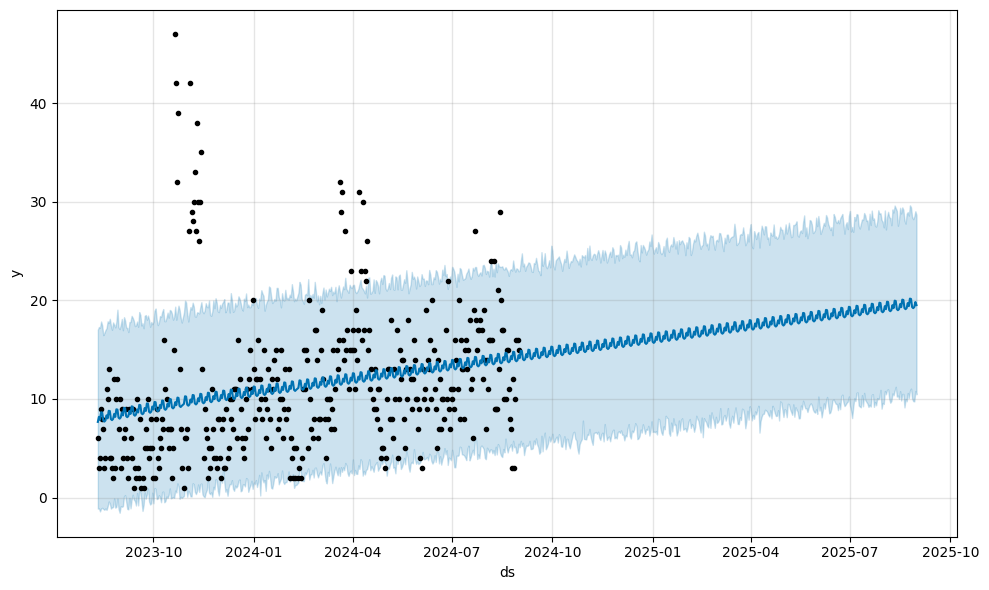

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


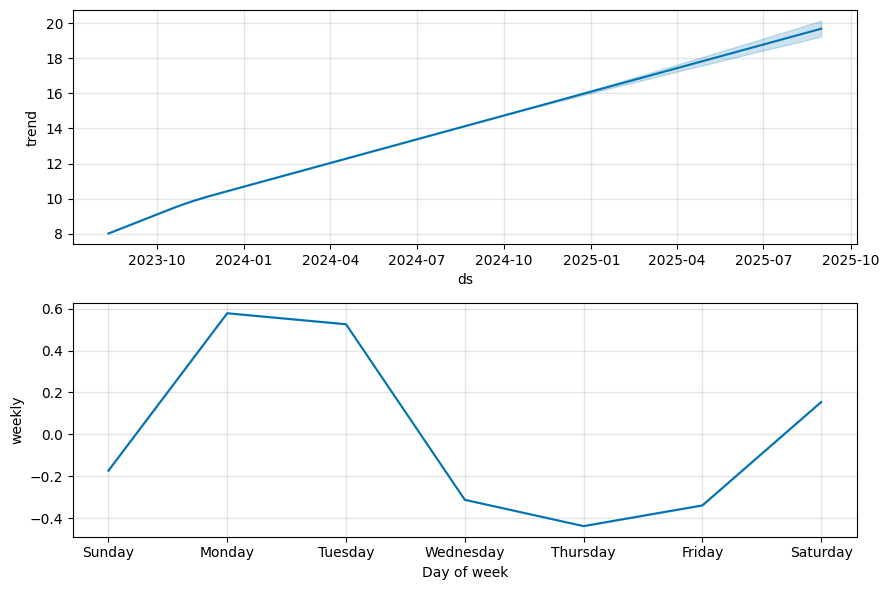

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

### 4.2 - Dự đoán Views

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/GA4_Data.csv')

In [ ]:
# Convert to DataFrame
df01 = df.copy()
df01.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events
0,10/21/2023,190,47,44,60,42,67.283333,1441,9
1,1/8/2024,189,10,7,16,14,67.937500,1514,0
2,12/19/2023,162,12,8,18,14,80.111111,1290,0
3,12/26/2023,160,11,6,17,13,95.117647,1384,10
4,5/3/2024,141,13,11,13,9,64.307692,781,6


In [ ]:
df01 = df01.drop(columns=["Total users","New users","Sessions","Engaged sessions","Average engagement time per session","Event count","Key events"])
df01.head(5)

,Date,Views
0,10/21/2023,190
1,1/8/2024,189
2,12/19/2023,162
3,12/26/2023,160
4,5/3/2024,141


In [ ]:
df01.rename(columns={'Date': 'ds', 'Views': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df01['ds'] = pd.to_datetime(df01['ds'])

In [ ]:
df01.head()

,ds,y
0,2023-10-21,190
1,2024-01-08,189
2,2023-12-19,162
3,2023-12-26,160
4,2024-05-03,141


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df01)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/fcpvqw1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/olyypiyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84803', 'data', 'file=/tmp/tmp_w2g5i3z/fcpvqw1n.json', 'init=/tmp/tmp_w2g5i3z/olyypiyy.json', 'output', 'file=/tmp/tmp_w2g5i3z/prophet_modelxevav1fl/prophet_model-20240912040422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:04:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


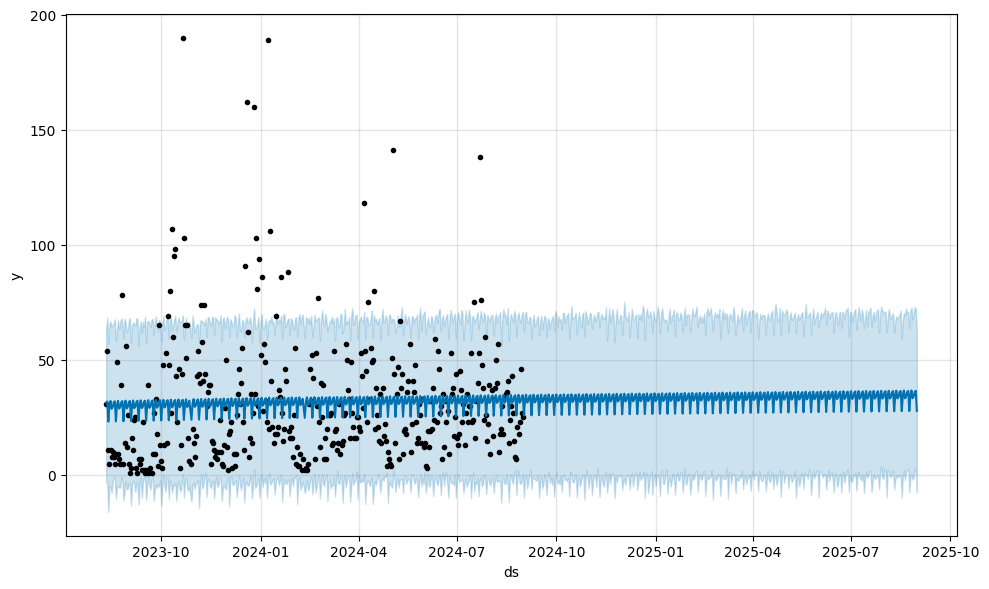

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


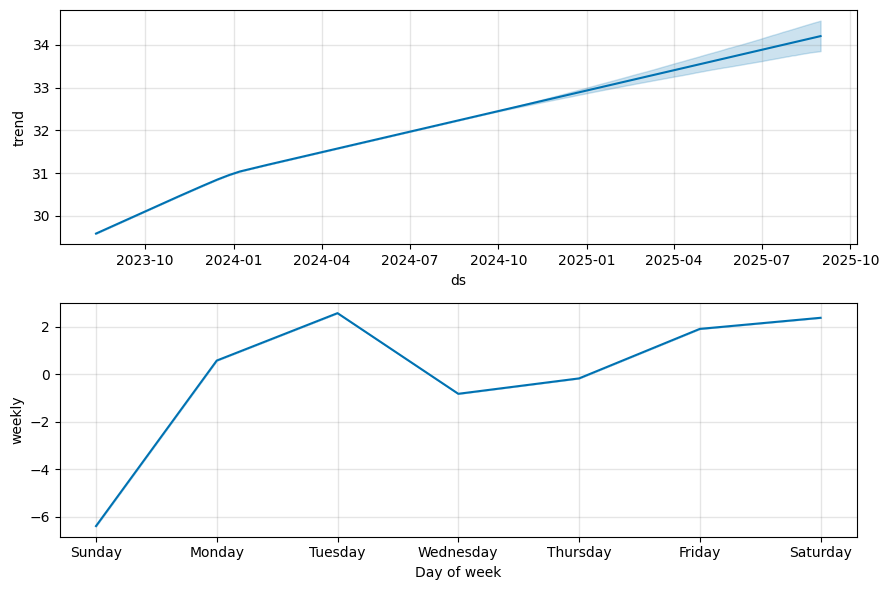

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

### 4.3 - Dự đoán Sessions

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/GA4_Data.csv')

In [ ]:
# Convert to DataFrame
df02 = df.copy()
df02.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events
0,10/21/2023,190,47,44,60,42,67.283333,1441,9
1,1/8/2024,189,10,7,16,14,67.937500,1514,0
2,12/19/2023,162,12,8,18,14,80.111111,1290,0
3,12/26/2023,160,11,6,17,13,95.117647,1384,10
4,5/3/2024,141,13,11,13,9,64.307692,781,6


In [ ]:
df02 = df02.drop(columns=["Total users","New users","Views","Engaged sessions","Average engagement time per session","Event count","Key events"])
df02.head(5)

,Date,Sessions
0,10/21/2023,60
1,1/8/2024,16
2,12/19/2023,18
3,12/26/2023,17
4,5/3/2024,13


In [ ]:
df02.rename(columns={'Date': 'ds', 'Sessions': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df02['ds'] = pd.to_datetime(df02['ds'])

In [ ]:
df02.head()

,ds,y
0,2023-10-21,60
1,2024-01-08,16
2,2023-12-19,18
3,2023-12-26,17
4,2024-05-03,13


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df02)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/yu_7pvi7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/itt9_fli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26491', 'data', 'file=/tmp/tmp_w2g5i3z/yu_7pvi7.json', 'init=/tmp/tmp_w2g5i3z/itt9_fli.json', 'output', 'file=/tmp/tmp_w2g5i3z/prophet_modelxpf3ebjq/prophet_model-20240912040424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:04:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:04:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


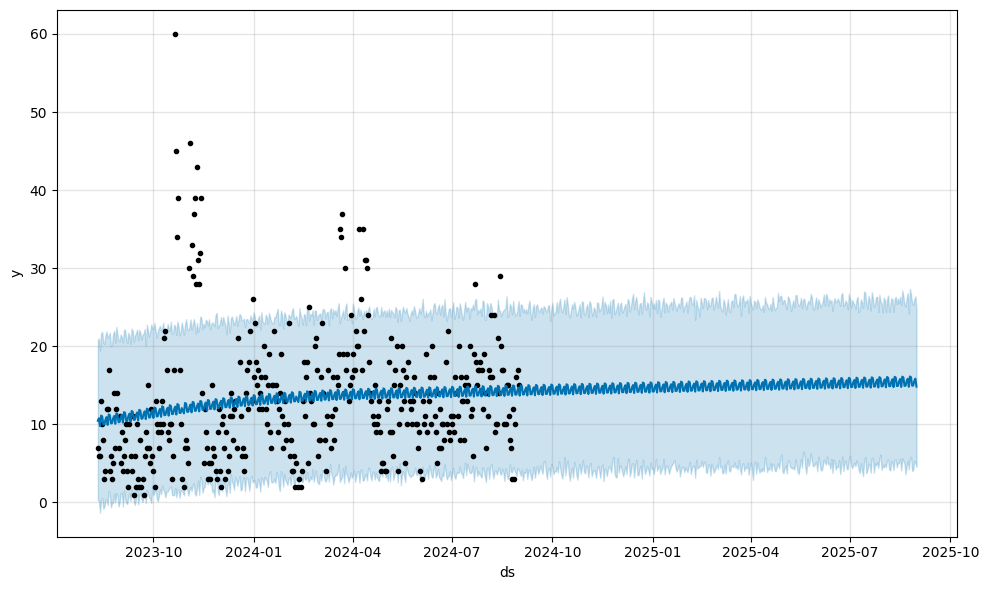

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


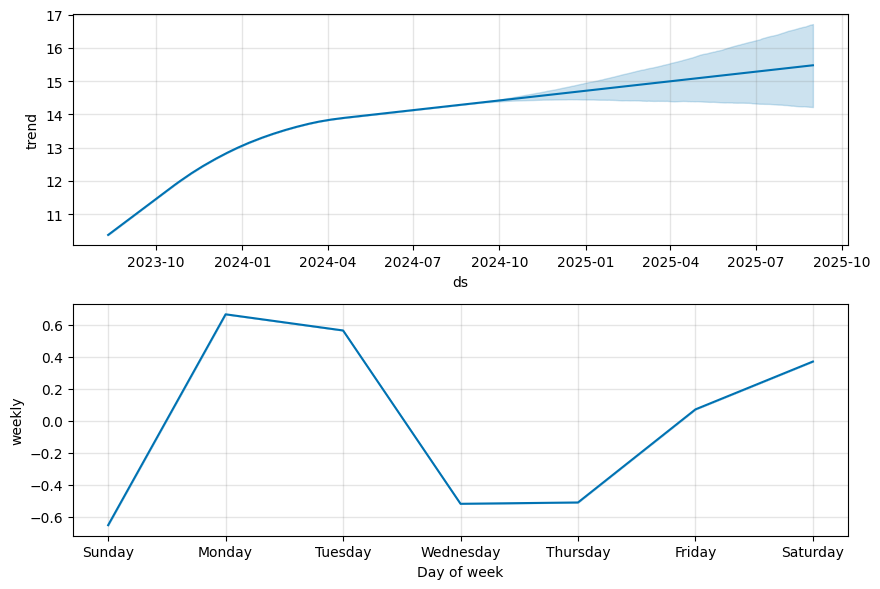

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

### 4.4 - Dự đoán Engaged Sessions

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/GA4_Data.csv')

In [ ]:
# Convert to DataFrame
df03 = df.copy()
df03.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events
0,10/21/2023,190,47,44,60,42,67.283333,1441,9
1,1/8/2024,189,10,7,16,14,67.937500,1514,0
2,12/19/2023,162,12,8,18,14,80.111111,1290,0
3,12/26/2023,160,11,6,17,13,95.117647,1384,10
4,5/3/2024,141,13,11,13,9,64.307692,781,6


In [ ]:
df03 = df03.drop(columns=["Total users","New users","Views","Sessions","Average engagement time per session","Event count","Key events"])
df03.head(5)

,Date,Engaged sessions
0,10/21/2023,42
1,1/8/2024,14
2,12/19/2023,14
3,12/26/2023,13
4,5/3/2024,9


In [ ]:
df03.rename(columns={'Date': 'ds', 'Engaged sessions': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df03['ds'] = pd.to_datetime(df03['ds'])

In [ ]:
df03.head()

,ds,y
0,2023-10-21,42
1,2024-01-08,14
2,2023-12-19,14
3,2023-12-26,13
4,2024-05-03,9


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df03)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/13msfjpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/5yq8ovh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22819', 'data', 'file=/tmp/tmp_w2g5i3z/13msfjpb.json', 'init=/tmp/tmp_w2g5i3z/5yq8ovh6.json', 'output', 'file=/tmp/tmp_w2g5i3z/prophet_model33nl4311/prophet_model-20240912040426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:04:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:04:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


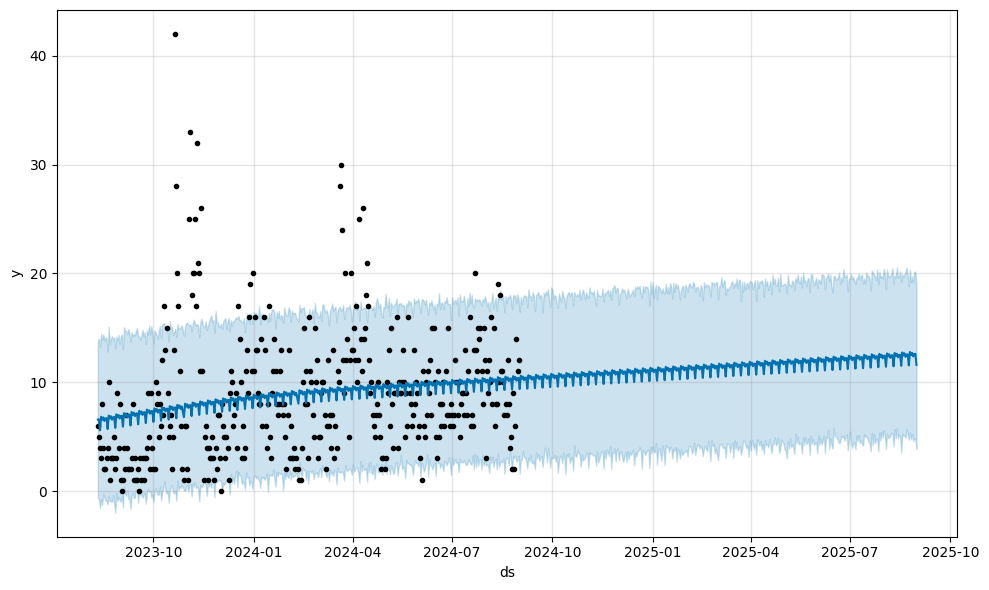

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


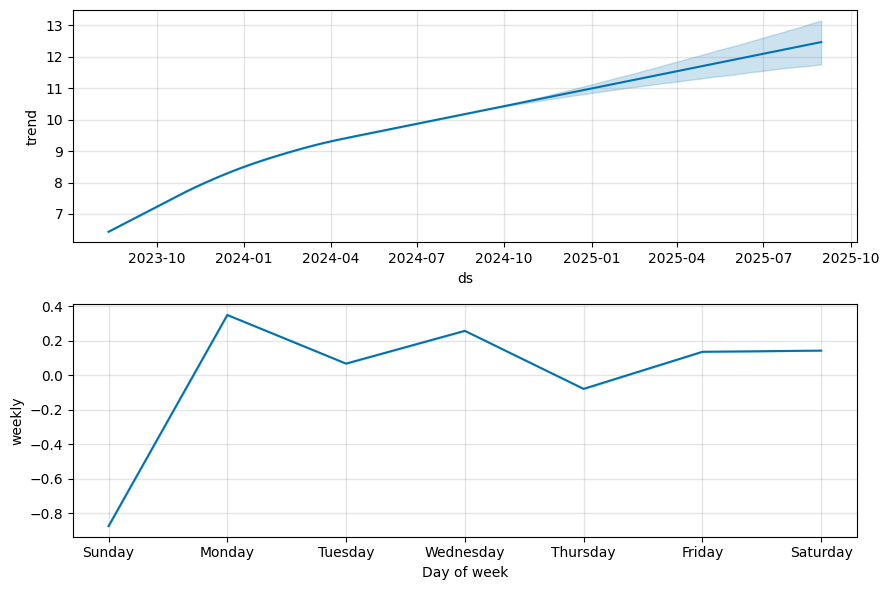

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

### 4.5 - Dự đoán Event Count

In [ ]:
# Import Facebook Prophet Learning Model
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/GA4_Data.csv')

In [ ]:
# Convert to DataFrame
df04 = df.copy()
df04.head()

,Date,Views,Total users,New users,Sessions,Engaged sessions,Average engagement time per session,Event count,Key events
0,10/21/2023,190,47,44,60,42,67.283333,1441,9
1,1/8/2024,189,10,7,16,14,67.937500,1514,0
2,12/19/2023,162,12,8,18,14,80.111111,1290,0
3,12/26/2023,160,11,6,17,13,95.117647,1384,10
4,5/3/2024,141,13,11,13,9,64.307692,781,6


In [ ]:
df04 = df04.drop(columns=["Total users","New users","Views","Sessions","Average engagement time per session","Engaged sessions","Key events"])
df04.head(5)

,Date,Event count
0,10/21/2023,1441
1,1/8/2024,1514
2,12/19/2023,1290
3,12/26/2023,1384
4,5/3/2024,781


In [ ]:
df04.rename(columns={'Date': 'ds', 'Event count': 'y'}, inplace=True)
# Ensure 'ds' is in datetime format
df04['ds'] = pd.to_datetime(df04['ds'])

In [ ]:
df04.head()

,ds,y
0,2023-10-21,1441
1,2024-01-08,1514
2,2023-12-19,1290
3,2023-12-26,1384
4,2024-05-03,781


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df04)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/6cn3d8n1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_w2g5i3z/3kucflrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58963', 'data', 'file=/tmp/tmp_w2g5i3z/6cn3d8n1.json', 'init=/tmp/tmp_w2g5i3z/3kucflrw.json', 'output', 'file=/tmp/tmp_w2g5i3z/prophet_modelavnokt0c/prophet_model-20240912040733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)

In [ ]:
# Generate forecast
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


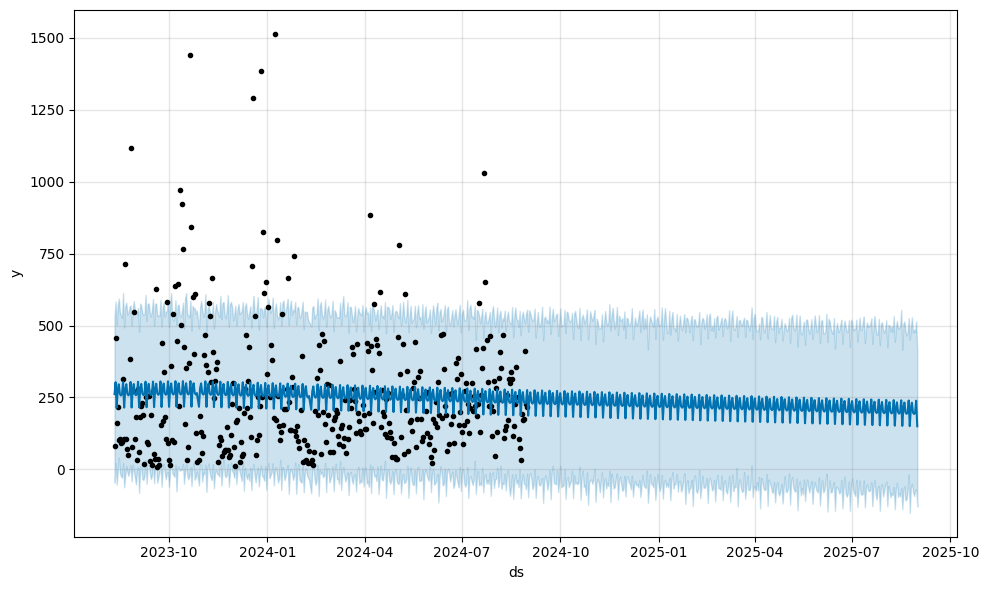

In [ ]:
# Plot forecast
fig = model.plot(forecast)
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


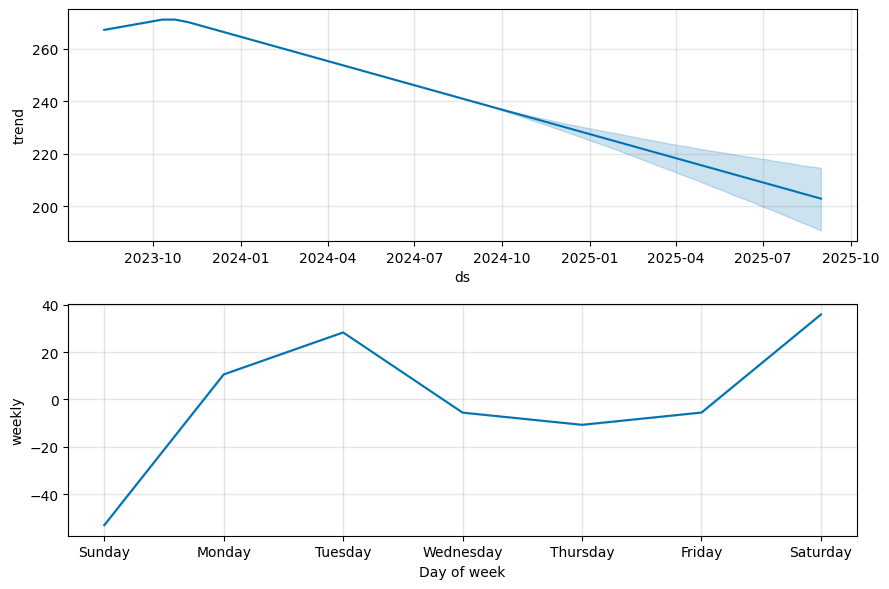

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()

# C - Kết luận và đề xuất

## 1 - Google Search Console

Note về Context: Website chỉ SEO mỗi Meta Tag, Meta Keyword và Meta Description chứ chưa hề triển khai Content SEO và tối ưu On/Off Page
Tổng quan vê Website với dữ liệu từ GSC trong vòng 1 năm:
*   Lượt nhấp: Trung bình 4 lượt nhấp/ngày
*   Lượt hiển thị: Trung bình 201 lượt hiển thị/ngày, Hiển thị tối thiểu là 29 lượt hiển thị/ngày
*   Click Through Rate (CTR): Trung bình 2.07%/ngày
*   Vị trí của Website: Vị trí trung bình của Website là 17.37



Insight từ EDA:
* Lượt nhấp ảnh hưởng **đáng kể** bởi lượt hiển thị, cũng là facts khi làm SEO or chạy Ads (+)
* Lượt nhấp càng cao thì CTR cũng tăng theo **đáng kể** (CTR = Lượt nhấp / Lượt hiển thị) (+)
* Lượt nhấp và CTR có ảnh hưởng ngược chiều với Vị trí Website, có thể suy luận rằng vị trí càng cao trong Top thì người dùng sẽ click vào càng nhiều (-)
* Vị trí ảnh hưởng bởi khả năng hiển thị (+)
*   Lượt nhấp và CTR tập trung ở Vị trí Website trong khoảng gần Top 15 (Xếp hạng của Google cao nhất là Top 1)
*   Để ý ta có thể thấy các vị trí Top 1 - Top 20 chủ yếu đều có Lượt hiển thị gần bằng 100, các vị trí từ Top 20 trở đi đều có Lượt hiển thị lớn hơn 100

Insight từ xây dựng mô hình hồi quy và ML:
* Các chỉ số đều cao nhất vào giữa tuần (Thứ 4 và thứ 5) và giảm mạnh vào cuối tuần (Thứ 7, Chủ nhật), Các chỉ số có xu hướng tăng dần đều và không có yếu tố mùa vụ.
* Ngoài ra, vẫn còn có 1 số Outlier trong mô hình dự đoán nhưng không đáng kể


Đề xuất:
*   Audit lại các từ khóa và các trang có xếp hạng thấp để cải thiện thứ hạng cũng như tăng các chỉ số chính cho toàn bộ Website
*   Nghiên cứu đẩy thêm các từ khóa và Content SEO mới để phân phối không bị drop vào cuối tuần



## 2 - Google Analytics 4

Note về Context: Website chỉ SEO mỗi Meta Tag, Meta Keyword và Meta Description chứ chưa hề triển khai Content SEO và tối ưu On/Off Page. GA4 đo được từ 60 - 80% Traffic đến từ nguồn Organic. Dữ liệu lấy từ GA4 là đã tính All Source chứ không chỉ mình Organic.
Tổng quan vê Website với dữ liệu từ GA4 trong vòng 1 năm:
*   Trung bình 1 ngày Website có 31 lượt View, Thời gian tương tác trung bình trên phiên (Session) là 32 giây
*   Trung bình 1 ngày Website có 11 User vào Website, 13 phiên trên Website, % New User là 75.52%
*   Tỷ lệ tương tác trung bình (Engagement Rate) của User là 66.26% (Bounce Rate được tính trên GA4 = 100% - Engagement Rate)
*   1 User trung bình xem 2 lượt/trang và 2 lượt/phiên, tương tác tổng với 24 event rồi mới thoát Website
*   1 User trung bình tương tác với 20 event trong 1 phiên



Insight từ EDA: Khi Traffic (Total User) tăng thì các Metrics khác tăng theo, 1 số MQH đặc biệt tương quan cao mà ta có thể để ý đó là giữa User và Session, giữa Engaged Session, Total Session, Average Session Time và Event Count (Correlation > 0.6). Xem lại ở phần B mục 2

Insight từ xây dựng mô hình hồi quy và ML:
*   Dựa vào phần 3 - Xây dựng mô hình hồi quy, các biến có R bình phương cao (> 0.8) ở trong mô hình hồi quy đó là: Total User, View, Sessions, Engaged Sessions, Event Count
*   Biến Engagement Rate  có R bình phương trung bình (> 0.6), biến Average time per Session, Key Event có R bình phương thấp (< 0.5)
---
*   Theo như phần 4 - Xây dựng ML, Total User và Sessions có xu hướng tăng vào thứ 2, thứ 3, giảm mạnh vào thứ 4 đến thứ 7 thì bắt đầu tăng dần trở lại
*   View và Event Count có xu hướng giảm nhẹ vào thứ 4 và bắt đầu tăng dần đều từ thứ 5 cho đến thứ 3 đầu tuần
*   Engaged Session có xu hướng giảm nhẹ vào thứ 3 và thứ 5 và đạt đỉnh vào thứ 2 hàng tuần


Đề xuất:
*   Theo dõi thứ 4 hàng tuần thông qua live user của GA4, Path Exploration và Heatmap Tracking Tool như Clarity để điều tra thêm về xu hướng giảm trong Total User và Session
*   Clean các Outlier để vẽ lại mô hình hồi quy cho các biến có R bình phương trung bình, thấp hoặc lấy thêm dữ liệu sau đó để bổ sung

